In [1]:
import sys

!{sys.executable} -m pip install torch
!{sys.executable} -m pip install qiskit
!{sys.executable} -m pip install pylatexenc
!{sys.executable} -m pip install torchvision
!{sys.executable} -m pip install numpy
!{sys.executable} -m pip install tqdm
!{sys.executable} -m pip install matplotlib
!{sys.executable} -m pip install itertools

You should consider upgrading via the '/usr/local/Cellar/jupyterlab/2.2.8/libexec/bin/python3.8 -m pip install --upgrade pip' command.


You should consider upgrading via the '/usr/local/Cellar/jupyterlab/2.2.8/libexec/bin/python3.8 -m pip install --upgrade pip' command.
You should consider upgrading via the '/usr/local/Cellar/jupyterlab/2.2.8/libexec/bin/python3.8 -m pip install --upgrade pip' command.
You should consider upgrading via the '/usr/local/Cellar/jupyterlab/2.2.8/libexec/bin/python3.8 -m pip install --upgrade pip' command.
You should consider upgrading via the '/usr/local/Cellar/jupyterlab/2.2.8/libexec/bin/python3.8 -m pip install --upgrade pip' command.
You should consider upgrading via the '/usr/local/Cellar/jupyterlab/2.2.8/libexec/bin/python3.8 -m pip install --upgrade pip' command.
You should consider upgrading via the '/usr/local/Cellar/jupyterlab/2.2.8/libexec/bin/python3.8 -m pip install --upgrade pip' command.
ERROR: Could not find a version that satisfies the requirement itertools (from versions: none)
ERROR: No matching distribution found for itertools
You should consider upgrading via the '/usr

In [2]:
import torch
from torch.autograd import Function
import torch.optim as optim
import torch.nn as nn

In [3]:
from qiskit import execute
from qiskit.circuit import Parameter,ControlledGate
from qiskit import Aer
import qiskit
import numpy as np

In [4]:
from tqdm import tqdm

In [5]:
from matplotlib import pyplot as plt
%matplotlib inline

In [6]:
np.random.seed = 42

NUM_QUBITS = 1
NUM_SHOTS = 5000
SHIFT = np.pi/4
LEARNING_RATE = 0.01
MOMENTUM = 0.5

SIMULATOR = Aer.get_backend('qasm_simulator')

In [7]:
# create list of all possible outputs of quantum circuit (2**NUM_QUBITS possible)
import itertools

def create_QC_OUTPUTS():
    measurements = list(itertools.product([0, 1], repeat=NUM_QUBITS))
    return [''.join([str(bit) for bit in measurement]) for measurement in measurements]

QC_OUTPUTS = create_QC_OUTPUTS()
print(QC_OUTPUTS)

['0', '1']


# Contruct QuantumCircuit QFT Class

In [8]:
class QuantumCircuit:
    def __init__(self, n_qubits, backend, shots):
        self.n_qubits = n_qubits
        self.circuit = qiskit.QuantumCircuit(n_qubits)
        self.thetas = { k: Parameter('Theta'+str(k)) for k in range(self.n_qubits) }
        
        all_qubits = [i for i in range(n_qubits)]
        
        self.circuit.h(all_qubits)
        self.circuit.barrier()
        for k in range(n_qubits):
            self.circuit.ry(self.thetas[k], k)
            
        self.circuit.measure_all()
        
        self.backend = backend
        self.shots = shots
        
    def N_qubits_expectation_Z(self, counts, shots, n_qubits):
        expects = np.zeros(len(QC_OUTPUTS))
        for k in range(len(QC_OUTPUTS)):
            key = QC_OUTPUTS[k]
            perc = counts.get(key, 0) / shots
            expects[k] = perc
        return expects
    
    def run(self, i):
        params = i
        
        job_sim = execute(self.circuit, 
                          self.backend, 
                          shots = self.shots, 
                          parameter_binds = [{ self.thetas[k]: params[k].item() for k in range(self.n_qubits) }])
        
        result_sim = job_sim.result()
        counts = result_sim.get_counts(self.circuit)
        
        return self.N_qubits_expectation_Z(counts, self.shots, self.n_qubits)

Expected value for rotation [pi/4]: [0.1498 0.8502]


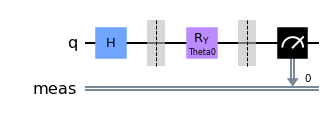

In [9]:
circuit = QuantumCircuit(NUM_QUBITS, SIMULATOR, NUM_SHOTS)
print(f'Expected value for rotation [pi/4]: {circuit.run(torch.Tensor([np.pi/4] * len(QC_OUTPUTS)))}')
circuit.circuit.draw(output='mpl')

In [10]:
class TorchCircuit(Function):
    @staticmethod
    def forward(ctx, i):
        if not hasattr(ctx, 'QuantumCircuit'):
            ctx.QuantumCircuit = QuantumCircuit(NUM_QUBITS, SIMULATOR, shots=NUM_SHOTS)
        
        exp_value = ctx.QuantumCircuit.run(i)
        
        result = torch.Tensor([exp_value])
        
        ctx.save_for_backward(result, i)
        
        return result
    
    @staticmethod
    def backward(ctx, grad_output):
        forward_tensor,i = ctx.saved_tensors
        
        input_numbers = i
        gradients = torch.Tensor()
        
        for k in range(NUM_QUBITS):
            shift_right = input_numbers.detach().clone()
            shift_right[k] = shift_right[k] + SHIFT
            
            shift_left = input_numbers.detach().clone()
            shift_left[k] = shift_left[k] - SHIFT
            
            expectation_right = ctx.QuantumCircuit.run(shift_right)
            expectation_left = ctx.QuantumCircuit.run(shift_left)
            
            gradient = torch.tensor([expectation_right]) - torch.tensor([expectation_left])
            gradient = gradient / torch.norm(gradient)
            
            gradients = torch.cat((gradients, gradient.float()))
            
        result = torch.Tensor(gradients)
        
        return (result.float() * grad_output.float()).T

In [11]:
x = torch.tensor([np.pi/4] * NUM_QUBITS, requires_grad=True)
qc = TorchCircuit.apply

y1 = qc(x)
print(f'y1 after quantum layer: {y1}')
y1 = nn.Linear(2**NUM_QUBITS, 1)(y1.float())

y1.backward()
print(f'x.grad = {x.grad}')

y1 after quantum layer: tensor([[0.1472, 0.8528]], grad_fn=<TorchCircuitBackward>)
x.grad = tensor([-0.3479])


100%|██████████| 100/100 [00:03<00:00, 26.20it/s]


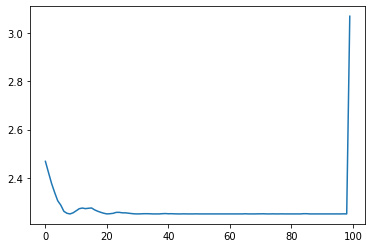

In [12]:
qc = TorchCircuit.apply

def cost(x):
    target = -1
    expval = qc(x)[0]
    
    val = sum([(i + 1) * expval[i] for i in range(2**NUM_QUBITS)]) / 2**NUM_QUBITS
    
    return torch.abs(target - val) ** 2, expval


x = torch.tensor([-np.pi/4] * NUM_QUBITS, requires_grad=True)
opt = optim.Adam([x], lr = 0.1)

num_epoch = 100

loss_list = []
expval_list = []

for i in tqdm(range(num_epoch)):
    opt.zero_grad()
    loss, expval = cost(x)
    loss.backward()
    
    opt.step()
    loss_list.append(loss.item())
    expval_list.append(expval)
    
plt.plot(loss_list)

In [13]:
from torch.functional import F

In [14]:
import numpy as np
import torchvision
from torchvision import datasets, transforms

In [15]:
TRAIN_DATA_PATH = "./data/hurricane_damage_dataset/test/"
TEST_DATA_PATH = "./data/hurricane_damage_dataset/validation_another/"

TRANSFORM_IMG = transforms.Compose([
    transforms.Resize(128),
    transforms.CenterCrop(128),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225] )
    ])


# train_samples = 900
# test_samples = 100

train_samples = 2000
test_samples = 2000


train_data = torchvision.datasets.ImageFolder(root=TRAIN_DATA_PATH, transform=TRANSFORM_IMG)
# train_idx = np.append(np.where(train_data.targets == 0)[0][:train_samples], 
#                 np.where(train_data.targets == 1)[0][:train_samples])

X_train = torch.utils.data.Subset(train_data, np.random.choice(len(train_data), train_samples, replace=False))


# train_data.data = train_data.data[train_idx]
# train_data.targets = train_data.targets[train_idx]

test_data = torchvision.datasets.ImageFolder(root=TEST_DATA_PATH, transform=TRANSFORM_IMG)
# test_idx = np.append(np.where(test_data.targets == 0)[0][:test_samples], 
#                 np.where(test_data.targets == 1)[0][:test_samples])

# test_data.data = test_data.data[test_idx]
# test_data.targets = test_data.targets[test_idx]

X_test = torch.utils.data.Subset(test_data, np.random.choice(len(test_data), test_samples, replace=False))


train_loader = torch.utils.data.DataLoader(X_train, batch_size=1, shuffle=True, pin_memory=True)
test_loader  = torch.utils.data.DataLoader(X_test, batch_size=1, shuffle=True) 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

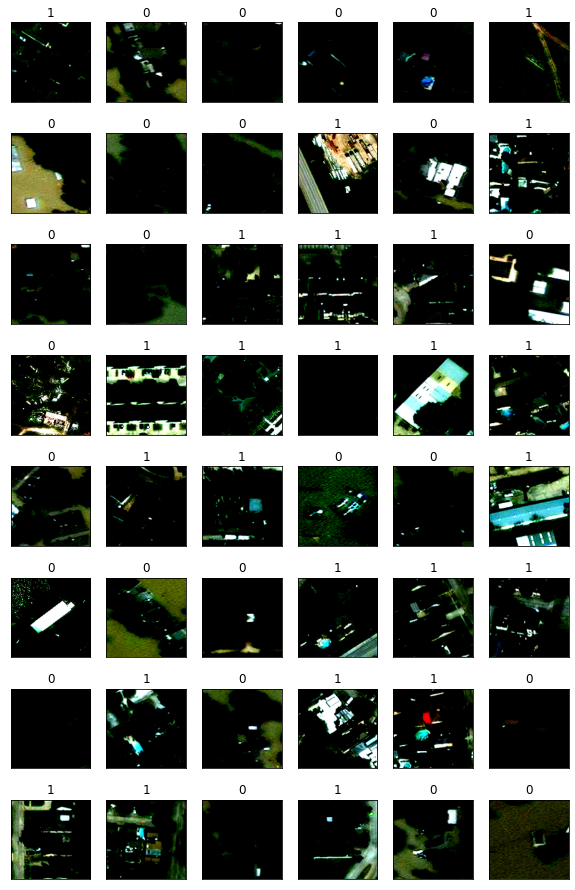

In [16]:
n_sample_shape = (8, 6)
count = 0
fig, axes = plt.subplots(nrows=n_sample_shape[0], ncols=n_sample_shape[1], figsize=(10, 2*n_sample_shape[0]))

# classes_map = {
#     0: 'T-shirt/top',
#     1: 'Trouser',
#     2: 'Pullover',
#     3: 'Dress',
#     4: 'Coat',
#     5: 'Sandal',
#     6: 'Shirt',
#     7: 'Sneaker',
#     8: 'Bag',
#     9: 'Ankle boot'
# }

# network.eval()
# with torch.no_grad():
for batch_idx, (data, target) in enumerate(test_loader):
    if count == n_sample_shape[0]*n_sample_shape[1]:
        break

#     prediction = network.predict(data).item()

    prepared_img = data[0].numpy().squeeze()

    axes[count // n_sample_shape[1]][count % n_sample_shape[1]].imshow(data[0].permute(1, 2, 0))

    axes[count // n_sample_shape[1]][count % n_sample_shape[1]].set_xticks([])
    axes[count // n_sample_shape[1]][count % n_sample_shape[1]].set_yticks([])
    axes[count // n_sample_shape[1]][count % n_sample_shape[1]].set_title(target.item())

    count += 1

In [17]:

# n_samples = 1000

# X_train = datasets.FashionMNIST(root='./data', 
#                                 train=True,
#                                 download=True,
#                                 transform=transforms.Compose([transforms.ToTensor()]))

# idx = np.append(np.where(X_train.targets == 0)[0][:n_samples], 
#                 np.where(X_train.targets == 1)[0][:n_samples])
# # idx = np.append(idx, 
# #                 np.where(X_train.targets == 2)[0][:n_samples])
# # idx = np.append(idx, 
# #                 np.where(X_train.targets == 3)[0][:n_samples])

# X_train.data = X_train.data[idx]
# X_train.targets = X_train.targets[idx]

In [18]:
# train_loader = torch.utils.data.DataLoader(X_train, batch_size=1, shuffle=True, pin_memory=True)

In [19]:
# n_samples = 50

# X_test = datasets.FashionMNIST(root='./data', 
#                                train=False,
#                                download=True,
#                                transform=transforms.Compose([transforms.ToTensor()]))

# idx = np.append(np.where(X_test.targets == 0)[0][:n_samples], 
#                 np.where(X_test.targets == 1)[0][:n_samples])
# # idx = np.append(idx, 
# #                 np.where(X_test.targets == 2)[0][:n_samples])
# # idx = np.append(idx, 
# #                 np.where(X_test.targets == 3)[0][:n_samples])

# X_test.data = X_test.data[idx]
# X_test.targets = X_test.targets[idx]

In [20]:
# test_loader = torch.utils.data.DataLoader(X_test, batch_size=1, shuffle=True)

# Building network

In [21]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
#         self.conv1 = nn.Conv2d(3, 10, kernel_size=5)
#         self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
#         self.conv3 = nn.Conv2d(20, 20, kernel_size=5)
#         self.conv4 = nn.Conv2d(20, 20, kernel_size=5)
#         self.conv2_drop = nn.Dropout2d()
#         self.fc1 = nn.Linear(320, 50)
#         self.fc2 = nn.Linear(50, NUM_QUBITS)
#         self.qc = TorchCircuit.apply
#         self.qcsim = nn.Linear(NUM_QUBITS, 1)

        DROPOUT = 0.5
    
        self.conv1 = nn.Conv2d(3, 32, kernel_size = 3, stride = 1, padding = 1)
#         self.convnorm1 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(2, 2)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=6, stride=1, padding=1)
#         self.convnorm2 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d((2, 2))

        self.conv3 = nn.Conv2d(64, 64, kernel_size = 6, stride = 1, padding = 1)
#         self.convnorm3 = nn.BatchNorm2d(64)
        self.pool3 = nn.AvgPool2d((2, 2))

        self.dropout = nn.Dropout(DROPOUT)
        self.linear1 = nn.Linear(64 * 13 * 13, 16)
#         self.linear1_bn = nn.BatchNorm1d(16)
        self.linear2 = nn.Linear(16, NUM_QUBITS)
#         self.linear2_bn = nn.BatchNorm1d(NUM_QUBITS)
        self.qc = TorchCircuit.apply
        self.sigmoid = torch.sigmoid
        self.relu = torch.relu

        
        
    def forward(self, x):
#         x = F.relu(F.max_pool2d(self.conv1(x), 2))
#         x = F.relu(F.max_pool2d(self.conv2(x), 2))
#         x = F.relu(F.max_pool2d(self.conv3(x), 2))
#         x = F.relu(F.max_pool2d(self.conv2_drop(self.conv4(x)), 2))
#         x = x.view(-1, 320)
#         x = F.relu(self.fc1(x))
#         x = F.dropout(x, training=self.training)
#         x = self.fc2(x)
#         x = np.pi*torch.tanh(x)
        
#         MODE = 'QC'
        
#         if MODE == 'QC':
#             x = self.qc(x[0])
#         else:
#             x = self.qcsim(x)
            
#         x = torch.sigmoid(x)
#         x = torch.cat((x, 1-x), -1)
        
#         return x

        x = self.pool1(self.relu(self.conv1(x)))
        x = self.pool2(self.relu(self.conv2(x)))
        x = self.pool3(self.relu(self.conv3(x)))
        x = x.view(-1, 64 * 13 * 13)
        x = self.dropout(self.relu(self.linear1(x)))
#         x = self.dropout(self.relu(self.linear2(x)))
        x = np.pi*torch.tanh(self.linear2(x))


#         x = self.pool1(self.convnorm1(self.relu(self.conv1(x))))
#         x = self.pool2(self.convnorm2(self.relu(self.conv2(x))))
#         x = self.pool3(self.convnorm3(self.relu(self.conv3(x))))
#         x = x.view(-1, 64 * 13 * 13)
#         x = self.dropout(self.linear1_bn(self.relu(self.linear1(x))))
#         x = self.dropout(self.linear2_bn(self.relu(self.linear2(x))))
        
        x = self.qc(x[0])
        
        x = self.sigmoid(x)
        
        x = torch.cat((x, 1-x), -1)
        
        return x
    
    
    def predict(self, x):
        
        pred = self.forward(x)
        ans = torch.argmax(pred[0]).item()
        
        return torch.tensor(ans)
    
# network = Net()
# optimizer = optim.Adam(network.parameters(), lr=0.001)

LR = 0.01

network = Net()
# optimizer = torch.optim.SGD(network.parameters(), lr = LR, momentum = 0.9)



In [22]:
def train_network(network, optimizer, train_loader, val_loader):
    epochs = 50
#     epochs = 20
    criterion = nn.CrossEntropyLoss()

    loaders = {
        'train': train_loader,
        'val': val_loader
    }
    
    loss_results = {
        'train': [],
        'val': []
    }

    acc_results = {
        'train': [],
        'val': []
    }

    loaders = {
        'train': train_loader,
        'val': test_loader
    }

    for epoch in range(epochs):
        total_loss = {
            'train': [],
            'val': []
        }

        total_acc = {
            'train': [],
            'val': []
        }


        for phase in ['train', 'val']:
            if phase == 'train':
                network.train(True)
            else:
                network.train(False)

            correct = 0
            number = 0

            for batch_idx, (data, target) in enumerate(loaders[phase]):
                optimizer.zero_grad()
                output = network(data)

                loss = criterion(output, target)

                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                total_loss[phase].append(loss.item())

                _, predicted = torch.max(output.data, 1)
                number += target.size(0)
                correct += (predicted == target).sum().item()

            loss_results[phase].append(sum(total_loss[phase]) / len(total_loss[phase]))
            acc_results[phase].append(100 * correct / number)

        progress = 100.0 * (epoch + 1) / epochs

        print(f'Training [{int(progress)}%]\tTraining loss {loss_results["train"][-1]}\tValidation loss {loss_results["val"][-1]}\tTraining acc {acc_results["train"][-1]}\tValidation acc {acc_results["val"][-1]}')
        
    return {
        'train_loss': loss_results["train"][-1],
        'val_loss': loss_results["val"][-1],
        'train_acc': acc_results["train"][-1],
        'val_acc': acc_results["val"][-1]
    }


In [ ]:
from sklearn.model_selection import KFold
from torch.utils.data import DataLoader, ConcatDataset

def reset_weights(m):
  '''
    Try resetting model weights to avoid
    weight leakage.
  '''
  for layer in m.children():
    if hasattr(layer, 'reset_parameters'):
        layer.reset_parameters()

dataset = ConcatDataset([X_train, X_test])

k_folds = 5

kfold = KFold(n_splits=k_folds, shuffle=True)

results = {}

print('--------------------------------')

for fold, (train_ids, test_ids) in enumerate(kfold.split(dataset)):
    # Print
    print(f'FOLD {fold}')
    print('--------------------------------')
  
    train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids)
    test_subsampler = torch.utils.data.SubsetRandomSampler(test_ids)
    
    # Define data loaders for training and testing data in this fold
    trainloader = torch.utils.data.DataLoader(
                      dataset, 
                      batch_size=1, sampler=train_subsampler)
    testloader = torch.utils.data.DataLoader(
                      dataset,
                      batch_size=1, sampler=test_subsampler)

    network = Net()
    network.apply(reset_weights)
    
    optimizer = optim.Adam(network.parameters(), lr=0.00001)
#     optimizer = torch.optim.SGD(network.parameters(), lr = LR, momentum = 0.9)
    
    result = train_network(network, optimizer, trainloader, testloader)
    
    results[fold] = result
    
    print(result)
    print('--------------------------------')

print('--------------------------------')
print('FINAL RESULTS')
print('--------------------------------')
print(results)
    

--------------------------------
FOLD 0
--------------------------------
Training [2%]	Training loss 1.242320208735764	Validation loss 1.2074202716350555	Training acc 68.75	Validation acc 86.55
Training [4%]	Training loss 1.23486020360142	Validation loss 1.271309061229229	Training acc 71.46875	Validation acc 50.0
Training [6%]	Training loss 1.2713073034584523	Validation loss 1.271330712735653	Training acc 49.90625	Validation acc 49.85
Training [8%]	Training loss 1.2713345369324087	Validation loss 1.2712511556744575	Training acc 48.59375	Validation acc 51.2
Training [10%]	Training loss 1.2713189070299267	Validation loss 1.2712655238509178	Training acc 50.1875	Validation acc 49.9
Training [12%]	Training loss 1.27131871689111	Validation loss 1.2713335013389588	Training acc 49.71875	Validation acc 50.15
Training [14%]	Training loss 1.2712662141770124	Validation loss 1.271317477285862	Training acc 51.5	Validation acc 50.35
Training [16%]	Training loss 1.2713218987733126	Validation loss 1.27

Training [32%]	Training loss 1.2713109279051422	Validation loss 1.2713130986094474	Training acc 50.65625	Validation acc 49.9
Training [34%]	Training loss 1.2713175471872091	Validation loss 1.2713093411922456	Training acc 49.40625	Validation acc 49.9
Training [36%]	Training loss 1.271349336989224	Validation loss 1.2713907641172408	Training acc 48.96875	Validation acc 47.3
Training [38%]	Training loss 1.2713316813483835	Validation loss 1.27129436647892	Training acc 48.875	Validation acc 50.35
Training [40%]	Training loss 1.2712823130190372	Validation loss 1.2712366681098939	Training acc 50.1875	Validation acc 50.65
Training [42%]	Training loss 1.2713119145855307	Validation loss 1.271300242125988	Training acc 50.875	Validation acc 50.0
Training [44%]	Training loss 1.2713662657886744	Validation loss 1.2713350157737733	Training acc 47.78125	Validation acc 50.2
Training [46%]	Training loss 1.2712893785908819	Validation loss 1.271226147532463	Training acc 51.25	Validation acc 50.95
Training [

Training [62%]	Training loss 1.2712633522972465	Validation loss 1.2713462253808976	Training acc 51.3125	Validation acc 49.45
Training [64%]	Training loss 1.2712628891691566	Validation loss 1.271285440981388	Training acc 50.71875	Validation acc 49.7
Training [66%]	Training loss 1.2713641112297773	Validation loss 1.2713369761705398	Training acc 49.09375	Validation acc 49.15
Training [68%]	Training loss 1.2713092819973826	Validation loss 1.2713150191307068	Training acc 51.0	Validation acc 50.9
Training [70%]	Training loss 1.271275339089334	Validation loss 1.2713234933018684	Training acc 51.15625	Validation acc 50.65
Training [72%]	Training loss 1.2712777175754308	Validation loss 1.271327931702137	Training acc 50.3125	Validation acc 49.1
Training [74%]	Training loss 1.2713595180585981	Validation loss 1.2712464755773545	Training acc 49.78125	Validation acc 51.25
Training [76%]	Training loss 1.271289320141077	Validation loss 1.2713119879364967	Training acc 50.0	Validation acc 48.9
Training [

Training [92%]	Training loss 1.2713249053433537	Validation loss 1.271271872460842	Training acc 49.21875	Validation acc 50.85
Training [94%]	Training loss 1.2713393874838947	Validation loss 1.2713891645669937	Training acc 49.8125	Validation acc 48.8
Training [96%]	Training loss 1.2712773858755826	Validation loss 1.2713643783926964	Training acc 50.84375	Validation acc 48.4
Training [98%]	Training loss 1.27133701171726	Validation loss 1.271297152876854	Training acc 49.125	Validation acc 50.3
Training [100%]	Training loss 1.271303950883448	Validation loss 1.2713372095823288	Training acc 50.40625	Validation acc 49.9
{'train_loss': 1.271303950883448, 'val_loss': 1.2713372095823288, 'train_acc': 50.40625, 'val_acc': 49.9}
--------------------------------
FOLD 4
--------------------------------
Training [2%]	Training loss 1.242453999556601	Validation loss 1.2106588535904885	Training acc 69.4375	Validation acc 85.35
Training [4%]	Training loss 1.2640705375000834	Validation loss 1.27133589851856

In [ ]:
# epochs = 25
# loss_func = nn.CrossEntropyLoss()

# loss_results = {
#     'train': [],
#     'val': []
# }

# acc_results = {
#     'train': [],
#     'val': []
# }

# loaders = {
#     'train': train_loader,
#     'val': test_loader
# }

# for epoch in range(epochs):
#     total_loss = {
#         'train': [],
#         'val': []
#     }
    
#     total_acc = {
#         'train': [],
#         'val': []
#     }
    
    
#     for phase in ['train', 'val']:
#         if phase == 'train':
#             network.train(True)
#         else:
#             network.train(False)
        
#         correct = 0
#         number = 0
        
#         for batch_idx, (data, target) in enumerate(loaders[phase]):
#             optimizer.zero_grad()
#             output = network(data)
            
#             loss = loss_func(output, target)
            
#             if phase == 'train':
#                 loss.backward()
#                 optimizer.step()

#             total_loss[phase].append(loss.item())

#             _, predicted = torch.max(output.data, 1)
#             number += target.size(0)
#             correct += (predicted == target).sum().item()

#         loss_results[phase].append(sum(total_loss[phase]) / len(total_loss[phase]))
#         acc_results[phase].append(100 * correct / number)

#     progress = 100.0 * (epoch + 1) / epochs
    
#     print(f'Training [{int(progress)}%]\tTraining loss {loss_results["train"][-1]}\tValidation loss {loss_results["val"][-1]}\tTraining acc {acc_results["train"][-1]}\tValidation acc {acc_results["val"][-1]}')
    

In [ ]:
# plt.plot(loss_results["train"])
# plt.title(f'Hybrid NN training convergence for {NUM_QUBITS}-qubits')
# plt.xlabel('epoch')
# plt.ylabel('loss')

In [ ]:
# plt.plot(loss_results["val"])
# plt.title(f'Hybrid NN training convergence for {NUM_QUBITS}-qubits')
# plt.xlabel('epoch')
# plt.ylabel('loss')

# Test accuracy

In [ ]:
# accuracy = 0
# number = 0
# for batch_idx, (data, target) in enumerate(test_loader):
#     number += 1
#     output = network.predict(data).item()
#     accuracy += (output == target[0].item())*1

In [ ]:
# print(f'Performance on test data: {accuracy}/{number} = {accuracy/number*100}%')

In [ ]:
# n_sample_shape = (8, 6)
# count = 0
# fig, axes = plt.subplots(nrows=n_sample_shape[0], ncols=n_sample_shape[1], figsize=(10, 2*n_sample_shape[0]))

# classes_map = {
#     0: 'T-shirt/top',
#     1: 'Trouser',
#     2: 'Pullover',
#     3: 'Dress',
#     4: 'Coat',
#     5: 'Sandal',
#     6: 'Shirt',
#     7: 'Sneaker',
#     8: 'Bag',
#     9: 'Ankle boot'
# }

# network.eval()
# with torch.no_grad():
#     for batch_idx, (data, target) in enumerate(test_loader):
#         if count == n_sample_shape[0]*n_sample_shape[1]:
#             break
        
#         prediction = network.predict(data).item()
        
#         axes[count // n_sample_shape[1]][count % n_sample_shape[1]].imshow(data[0].numpy().squeeze(), cmap='gray')
        
#         axes[count // n_sample_shape[1]][count % n_sample_shape[1]].set_xticks([])
#         axes[count // n_sample_shape[1]][count % n_sample_shape[1]].set_yticks([])
#         axes[count // n_sample_shape[1]][count % n_sample_shape[1]].set_title(classes_map[prediction])
        
#         count += 1

In [ ]:
# --------------------------------
# FOLD 0
# --------------------------------
# Training [5%]	Training loss 1.2713040019571782	Validation loss 1.2713841915130615	Training acc 52.25	Validation acc 48.0
# Training [10%]	Training loss 1.2712882739305496	Validation loss 1.2710566103458405	Training acc 52.875	Validation acc 54.0
# Training [15%]	Training loss 1.2730600772798062	Validation loss 1.271704078912735	Training acc 49.75	Validation acc 43.0
# Training [20%]	Training loss 1.2715081848204135	Validation loss 1.271539865732193	Training acc 49.0	Validation acc 42.0
# Training [25%]	Training loss 1.2713461914658546	Validation loss 1.2715637326240539	Training acc 49.125	Validation acc 43.0
# Training [30%]	Training loss 1.2684558971226216	Validation loss 1.2665857326984407	Training acc 50.625	Validation acc 64.0
# Training [35%]	Training loss 1.2693231689929962	Validation loss 1.266489816904068	Training acc 50.625	Validation acc 58.0
# Training [40%]	Training loss 1.2670848762989044	Validation loss 1.2567837917804718	Training acc 52.125	Validation acc 64.0
# Training [45%]	Training loss 1.2734928634762763	Validation loss 1.2960739243030548	Training acc 51.5	Validation acc 39.0
# Training [50%]	Training loss 1.276393005400896	Validation loss 1.275971885919571	Training acc 51.0	Validation acc 49.0
# Training [55%]	Training loss 1.2707830184698106	Validation loss 1.254835444688797	Training acc 50.375	Validation acc 62.0
# Training [60%]	Training loss 1.2693792696297168	Validation loss 1.2642875134944915	Training acc 48.25	Validation acc 63.0
# Training [65%]	Training loss 1.2688490436971187	Validation loss 1.2634777295589448	Training acc 54.875	Validation acc 65.0
# Training [70%]	Training loss 1.2693090239167213	Validation loss 1.2707323276996612	Training acc 54.125	Validation acc 50.0
# Training [75%]	Training loss 1.2699298229813576	Validation loss 1.2712135899066925	Training acc 50.75	Validation acc 49.0
# Training [80%]	Training loss 1.2693007272481918	Validation loss 1.2711268961429596	Training acc 49.75	Validation acc 57.0
# Training [85%]	Training loss 1.27011230006814	Validation loss 1.2639606893062592	Training acc 51.875	Validation acc 62.0
# Training [90%]	Training loss 1.2682631067931651	Validation loss 1.2653585577011108	Training acc 49.625	Validation acc 65.0
# Training [95%]	Training loss 1.2684673349559308	Validation loss 1.2650301349163056	Training acc 51.875	Validation acc 61.0
# Training [100%]	Training loss 1.2672649760544301	Validation loss 1.2621156418323516	Training acc 52.0	Validation acc 63.0
# {'train_loss': 1.2672649760544301, 'val_loss': 1.2621156418323516, 'train_acc': 52.0, 'val_acc': 63.0}
# --------------------------------
# FOLD 1
# --------------------------------
# Training [5%]	Training loss 1.2711561396718025	Validation loss 1.2713571763038636	Training acc 54.625	Validation acc 49.0
# Training [10%]	Training loss 1.2712713450193405	Validation loss 1.2711388635635377	Training acc 51.0	Validation acc 52.0
# Training [15%]	Training loss 1.2712188230454922	Validation loss 1.2713743007183076	Training acc 54.25	Validation acc 52.0
# Training [20%]	Training loss 1.2713084408640862	Validation loss 1.2712275207042694	Training acc 50.625	Validation acc 51.0
# Training [25%]	Training loss 1.271255591660738	Validation loss 1.2713618230819703	Training acc 50.5	Validation acc 49.0
# Training [30%]	Training loss 1.2713359412550926	Validation loss 1.2711002552509307	Training acc 50.0	Validation acc 51.0
# Training [35%]	Training loss 1.2713090671598912	Validation loss 1.2716398465633392	Training acc 50.5	Validation acc 43.0
# Training [40%]	Training loss 1.27130484983325	Validation loss 1.270956585407257	Training acc 49.625	Validation acc 58.0
# Training [45%]	Training loss 1.271381655484438	Validation loss 1.2713790154457092	Training acc 47.75	Validation acc 56.0
# Training [50%]	Training loss 1.2713595023751258	Validation loss 1.2716060423851012	Training acc 48.0	Validation acc 42.0
# Training [55%]	Training loss 1.27139325350523	Validation loss 1.2714669132232665	Training acc 47.625	Validation acc 42.0
# Training [60%]	Training loss 1.2713483946025372	Validation loss 1.2711747992038727	Training acc 48.25	Validation acc 52.0
# Training [65%]	Training loss 1.271426661759615	Validation loss 1.271310373544693	Training acc 47.875	Validation acc 51.0
# Training [70%]	Training loss 1.271311458349228	Validation loss 1.2712471902370452	Training acc 48.625	Validation acc 54.0
# Training [75%]	Training loss 1.2712606117129326	Validation loss 1.2713367807865144	Training acc 51.875	Validation acc 50.0
# Training [80%]	Training loss 1.2713537722826005	Validation loss 1.2710598635673522	Training acc 49.75	Validation acc 54.0
# Training [85%]	Training loss 1.2713218136131763	Validation loss 1.2712825644016266	Training acc 49.625	Validation acc 50.0
# Training [90%]	Training loss 1.2712605008482933	Validation loss 1.2713338971138	Training acc 50.875	Validation acc 49.0
# Training [95%]	Training loss 1.2712448950111865	Validation loss 1.2715579450130463	Training acc 51.625	Validation acc 43.0
# Training [100%]	Training loss 1.2713646702468395	Validation loss 1.2712272417545318	Training acc 47.875	Validation acc 52.0
# {'train_loss': 1.2713646702468395, 'val_loss': 1.2712272417545318, 'train_acc': 47.875, 'val_acc': 52.0}
# --------------------------------
# FOLD 2
# --------------------------------
# Training [5%]	Training loss 1.269408836364746	Validation loss 1.2629344379901886	Training acc 51.25	Validation acc 59.0
# Training [10%]	Training loss 1.2698821611702442	Validation loss 1.2607777905464173	Training acc 50.75	Validation acc 59.0
# Training [15%]	Training loss 1.2707271677255632	Validation loss 1.254689575433731	Training acc 53.125	Validation acc 65.0
# Training [20%]	Training loss 1.2672448922693729	Validation loss 1.2618089282512666	Training acc 53.875	Validation acc 64.0
# Training [25%]	Training loss 1.2665497471392155	Validation loss 1.2579161715507508	Training acc 50.875	Validation acc 62.0
# Training [30%]	Training loss 1.2665442784130574	Validation loss 1.2488791847229004	Training acc 54.0	Validation acc 58.0
# Training [35%]	Training loss 1.2631700798869132	Validation loss 1.2489277565479278	Training acc 52.75	Validation acc 74.0
# Training [40%]	Training loss 1.264322398006916	Validation loss 1.2451178681850434	Training acc 55.125	Validation acc 70.0
# Training [45%]	Training loss 1.2580990378558636	Validation loss 1.2502973783016205	Training acc 56.625	Validation acc 70.0
# Training [50%]	Training loss 1.2571198339760303	Validation loss 1.2467223191261292	Training acc 59.0	Validation acc 70.0
# Training [55%]	Training loss 1.2570857799053192	Validation loss 1.242103440761566	Training acc 56.25	Validation acc 69.0
# Training [60%]	Training loss 1.2542369541525842	Validation loss 1.2429827892780303	Training acc 57.75	Validation acc 70.0
# Training [65%]	Training loss 1.2552563481032848	Validation loss 1.2404089295864105	Training acc 57.5	Validation acc 65.0
# Training [70%]	Training loss 1.2549612407386304	Validation loss 1.2402211427688599	Training acc 60.125	Validation acc 64.0
# Training [75%]	Training loss 1.2569134411215783	Validation loss 1.2422534143924713	Training acc 60.25	Validation acc 68.0
# Training [80%]	Training loss 1.2562930117547513	Validation loss 1.2475860679149628	Training acc 57.25	Validation acc 76.0
# Training [85%]	Training loss 1.256552858054638	Validation loss 1.2403889667987824	Training acc 54.875	Validation acc 78.0
# Training [90%]	Training loss 1.2540859939157962	Validation loss 1.2386716222763061	Training acc 59.125	Validation acc 75.0
# Training [95%]	Training loss 1.2542247666418553	Validation loss 1.2394179582595826	Training acc 57.75	Validation acc 75.0
# Training [100%]	Training loss 1.2537779240310192	Validation loss 1.2384221637248993	Training acc 57.875	Validation acc 72.0
# {'train_loss': 1.2537779240310192, 'val_loss': 1.2384221637248993, 'train_acc': 57.875, 'val_acc': 72.0}
# --------------------------------
# FOLD 3
# --------------------------------
# Training [5%]	Training loss 1.269745547324419	Validation loss 1.2595751953125	Training acc 51.0	Validation acc 55.0
# Training [10%]	Training loss 1.2649147541821002	Validation loss 1.2587570238113404	Training acc 50.125	Validation acc 57.0
# Training [15%]	Training loss 1.2651908756792545	Validation loss 1.2562245965003966	Training acc 54.875	Validation acc 55.0
# Training [20%]	Training loss 1.2640210647881032	Validation loss 1.2522896993160249	Training acc 54.625	Validation acc 58.0
# Training [25%]	Training loss 1.2635641066730023	Validation loss 1.2559601747989655	Training acc 55.875	Validation acc 67.0
# Training [30%]	Training loss 1.261120300143957	Validation loss 1.2509910464286804	Training acc 55.0	Validation acc 67.0
# Training [35%]	Training loss 1.2612401646375657	Validation loss 1.254228265285492	Training acc 56.875	Validation acc 73.0
# Training [40%]	Training loss 1.2584699304401874	Validation loss 1.2484909641742705	Training acc 58.375	Validation acc 70.0
# Training [45%]	Training loss 1.2576780661940574	Validation loss 1.2473998618125917	Training acc 59.0	Validation acc 73.0
# Training [50%]	Training loss 1.2606761075556279	Validation loss 1.2434079051017761	Training acc 53.875	Validation acc 70.0
# Training [55%]	Training loss 1.2603355376422405	Validation loss 1.2420167660713195	Training acc 60.125	Validation acc 66.0
# Training [60%]	Training loss 1.2567478659749032	Validation loss 1.2452275812625886	Training acc 59.375	Validation acc 70.0
# Training [65%]	Training loss 1.2586566933989525	Validation loss 1.2433249926567078	Training acc 58.75	Validation acc 70.0
# Training [70%]	Training loss 1.257256529033184	Validation loss 1.242205263376236	Training acc 58.75	Validation acc 69.0
# Training [75%]	Training loss 1.2545266807079316	Validation loss 1.2427861273288727	Training acc 60.875	Validation acc 72.0
# Training [80%]	Training loss 1.2554251086711883	Validation loss 1.2479699349403381	Training acc 58.5	Validation acc 75.0
# Training [85%]	Training loss 1.2535882148146629	Validation loss 1.2400157535076142	Training acc 60.875	Validation acc 68.0
# Training [90%]	Training loss 1.2578409291803836	Validation loss 1.245802619457245	Training acc 60.875	Validation acc 68.0
# Training [95%]	Training loss 1.2564126609265804	Validation loss 1.239680483341217	Training acc 59.5	Validation acc 74.0
# Training [100%]	Training loss 1.2555839760601522	Validation loss 1.2448029255867004	Training acc 61.125	Validation acc 74.0
# {'train_loss': 1.2555839760601522, 'val_loss': 1.2448029255867004, 'train_acc': 61.125, 'val_acc': 74.0}
# --------------------------------
# FOLD 4
# --------------------------------
# Training [5%]	Training loss 1.2706508833169936	Validation loss 1.2717212617397309	Training acc 51.125	Validation acc 45.0
# Training [10%]	Training loss 1.2713414311408997	Validation loss 1.2718502593040466	Training acc 51.625	Validation acc 52.0
# Training [15%]	Training loss 1.268840634971857	Validation loss 1.259641511440277	Training acc 52.375	Validation acc 61.0
# Training [20%]	Training loss 1.2706086272001267	Validation loss 1.271511766910553	Training acc 51.875	Validation acc 41.0
# Training [25%]	Training loss 1.2704417909681798	Validation loss 1.2578164672851562	Training acc 50.625	Validation acc 56.0
# Training [30%]	Training loss 1.2739416702091695	Validation loss 1.3091101348400116	Training acc 50.375	Validation acc 29.0
# Training [35%]	Training loss 1.2720510618388652	Validation loss 1.283083279132843	Training acc 52.0	Validation acc 49.0
# Training [40%]	Training loss 1.2772650808095931	Validation loss 1.2940449965000154	Training acc 46.5	Validation acc 47.0
# Training [45%]	Training loss 1.2724123884737493	Validation loss 1.3077677488327026	Training acc 50.25	Validation acc 31.0
# Training [50%]	Training loss 1.271663848310709	Validation loss 1.2747195088863372	Training acc 51.875	Validation acc 52.0
# Training [55%]	Training loss 1.2717482993006706	Validation loss 1.2994661700725556	Training acc 51.125	Validation acc 44.0
# Training [60%]	Training loss 1.2721384331583976	Validation loss 1.3050875997543334	Training acc 55.5	Validation acc 33.0
# Training [65%]	Training loss 1.2767181491851807	Validation loss 1.2500154173374176	Training acc 48.75	Validation acc 65.0
# Training [70%]	Training loss 1.2713944962620736	Validation loss 1.252508192062378	Training acc 51.375	Validation acc 66.0
# Training [75%]	Training loss 1.2758624178171158	Validation loss 1.311160227060318	Training acc 47.25	Validation acc 33.0
# Training [80%]	Training loss 1.2744089122116566	Validation loss 1.3022055506706238	Training acc 48.75	Validation acc 37.0
# Training [85%]	Training loss 1.271161187440157	Validation loss 1.3027682042121886	Training acc 51.375	Validation acc 38.0
# Training [90%]	Training loss 1.2777218434214592	Validation loss 1.2757143568992615	Training acc 46.5	Validation acc 48.0
# Training [95%]	Training loss 1.2711623732745647	Validation loss 1.260113011598587	Training acc 52.0	Validation acc 60.0
# Training [100%]	Training loss 1.2767944864928722	Validation loss 1.2851086723804475	Training acc 48.75	Validation acc 49.0
# {'train_loss': 1.2767944864928722, 'val_loss': 1.2851086723804475, 'train_acc': 48.75, 'val_acc': 49.0}
# --------------------------------
# --------------------------------
# FINAL RESULTS
# --------------------------------
# {0: {'train_loss': 1.2672649760544301, 'val_loss': 1.2621156418323516, 'train_acc': 52.0, 'val_acc': 63.0}, 1: {'train_loss': 1.2713646702468395, 'val_loss': 1.2712272417545318, 'train_acc': 47.875, 'val_acc': 52.0}, 2: {'train_loss': 1.2537779240310192, 'val_loss': 1.2384221637248993, 'train_acc': 57.875, 'val_acc': 72.0}, 3: {'train_loss': 1.2555839760601522, 'val_loss': 1.2448029255867004, 'train_acc': 61.125, 'val_acc': 74.0}, 4: {'train_loss': 1.2767944864928722, 'val_loss': 1.2851086723804475, 'train_acc': 48.75, 'val_acc': 49.0}}

In [ ]:
# --------------------------------
# FOLD 0
# --------------------------------
# Training [2%]	Training loss 1.2679254261776804	Validation loss 1.2589798531532288	Training acc 51.96875	Validation acc 58.3
# Training [4%]	Training loss 1.2666350485384463	Validation loss 1.2610226368904114	Training acc 53.71875	Validation acc 61.0
# Training [6%]	Training loss 1.2628201104700565	Validation loss 1.2535730155110358	Training acc 54.5	Validation acc 63.85
# Training [8%]	Training loss 1.2599991418793797	Validation loss 1.2516645373106003	Training acc 56.53125	Validation acc 67.85
# Training [10%]	Training loss 1.257752307280898	Validation loss 1.243271408677101	Training acc 57.65625	Validation acc 62.25
# Training [12%]	Training loss 1.257849448211491	Validation loss 1.2548420981764794	Training acc 57.5	Validation acc 67.4
# Training [14%]	Training loss 1.2562938864156603	Validation loss 1.2453884350657463	Training acc 59.4375	Validation acc 67.65
# Training [16%]	Training loss 1.2568681947141886	Validation loss 1.2468155816793443	Training acc 59.90625	Validation acc 69.95
# Training [18%]	Training loss 1.2562615018710495	Validation loss 1.248184106528759	Training acc 59.875	Validation acc 71.25
# Training [20%]	Training loss 1.2548494939878583	Validation loss 1.2452817581892013	Training acc 60.3125	Validation acc 69.3
# Training [22%]	Training loss 1.255270396731794	Validation loss 1.246782880961895	Training acc 58.875	Validation acc 65.9
# Training [24%]	Training loss 1.2566638008132578	Validation loss 1.247227905511856	Training acc 58.1875	Validation acc 70.3
# Training [26%]	Training loss 1.2550132271647454	Validation loss 1.2452697586417198	Training acc 59.75	Validation acc 70.3
# Training [28%]	Training loss 1.2548591673746705	Validation loss 1.2447585433721542	Training acc 59.6875	Validation acc 67.05
# Training [30%]	Training loss 1.2554659409821034	Validation loss 1.2424566274285316	Training acc 58.1875	Validation acc 69.85
# Training [32%]	Training loss 1.2531568944826723	Validation loss 1.2451640965938569	Training acc 61.34375	Validation acc 71.75
# Training [34%]	Training loss 1.2540631843730807	Validation loss 1.2437986539006234	Training acc 59.875	Validation acc 69.75
# Training [36%]	Training loss 1.2527791120857001	Validation loss 1.2467571603655816	Training acc 61.625	Validation acc 70.3
# Training [38%]	Training loss 1.2535584166273475	Validation loss 1.242901982009411	Training acc 61.0	Validation acc 71.3
# Training [40%]	Training loss 1.2540672688558698	Validation loss 1.2393890882134437	Training acc 60.09375	Validation acc 71.05
# Training [42%]	Training loss 1.2544183913990856	Validation loss 1.2400638704895974	Training acc 60.15625	Validation acc 68.7
# Training [44%]	Training loss 1.2711248617619275	Validation loss 1.271306273162365	Training acc 50.6875	Validation acc 49.25
# Training [46%]	Training loss 1.271346749663353	Validation loss 1.2713534633517265	Training acc 49.34375	Validation acc 48.9
# Training [48%]	Training loss 1.2712795834988355	Validation loss 1.2713328236341477	Training acc 50.84375	Validation acc 49.1
# Training [50%]	Training loss 1.2712771097570659	Validation loss 1.2713781015276908	Training acc 50.78125	Validation acc 48.6
# Training [52%]	Training loss 1.2713617572560907	Validation loss 1.2712808910012245	Training acc 48.65625	Validation acc 51.05
# Training [54%]	Training loss 1.271295225918293	Validation loss 1.2713888001441955	Training acc 50.375	Validation acc 48.55
# Training [56%]	Training loss 1.2712682853639126	Validation loss 1.271326374232769	Training acc 52.0625	Validation acc 49.95
# Training [58%]	Training loss 1.2712991267070175	Validation loss 1.2712937582731247	Training acc 50.96875	Validation acc 50.7
# Training [60%]	Training loss 1.271348924562335	Validation loss 1.271356849849224	Training acc 48.3125	Validation acc 49.4
# Training [62%]	Training loss 1.2713598920404912	Validation loss 1.2712924817800522	Training acc 48.0	Validation acc 50.6
# Training [64%]	Training loss 1.2713100038841367	Validation loss 1.271338470995426	Training acc 49.90625	Validation acc 49.85
# Training [66%]	Training loss 1.2713450376689435	Validation loss 1.2712703823447227	Training acc 49.5	Validation acc 50.25
# Training [68%]	Training loss 1.2713089918345213	Validation loss 1.2713388697504997	Training acc 50.34375	Validation acc 48.9
# Training [70%]	Training loss 1.271331197731197	Validation loss 1.271270833671093	Training acc 49.75	Validation acc 51.2
# Training [72%]	Training loss 1.2712698869779706	Validation loss 1.2712258570194244	Training acc 51.71875	Validation acc 51.75
# Training [74%]	Training loss 1.2713418758288026	Validation loss 1.2713780938386916	Training acc 48.6875	Validation acc 48.35
# Training [76%]	Training loss 1.2712689054384827	Validation loss 1.271242346048355	Training acc 50.6875	Validation acc 52.25
# Training [78%]	Training loss 1.271336787827313	Validation loss 1.2713069723248482	Training acc 50.375	Validation acc 50.55
# Training [80%]	Training loss 1.2712628554180265	Validation loss 1.2712671197652816	Training acc 52.46875	Validation acc 51.8
# Training [82%]	Training loss 1.2712691736593842	Validation loss 1.2713078770041466	Training acc 51.09375	Validation acc 50.15
# Training [84%]	Training loss 1.2713083943724632	Validation loss 1.271328331232071	Training acc 50.25	Validation acc 49.65
# Training [86%]	Training loss 1.2713076130673289	Validation loss 1.2713649327754974	Training acc 50.65625	Validation acc 48.5
# Training [88%]	Training loss 1.2713064109161496	Validation loss 1.2713259904384613	Training acc 50.03125	Validation acc 50.2
# Training [90%]	Training loss 1.2713054986298085	Validation loss 1.2713404803276063	Training acc 50.625	Validation acc 49.95
# Training [92%]	Training loss 1.271325383707881	Validation loss 1.2713559694290162	Training acc 50.03125	Validation acc 49.75
# Training [94%]	Training loss 1.271369838565588	Validation loss 1.2712897826433183	Training acc 48.5	Validation acc 50.65
# Training [96%]	Training loss 1.2713754502683878	Validation loss 1.271368255198002	Training acc 49.3125	Validation acc 47.95
# Training [98%]	Training loss 1.2712869704142213	Validation loss 1.2712582868933677	Training acc 50.65625	Validation acc 51.5
# Training [100%]	Training loss 1.2712779772281646	Validation loss 1.271305297076702	Training acc 51.0	Validation acc 49.65
# {'train_loss': 1.2712779772281646, 'val_loss': 1.271305297076702, 'train_acc': 51.0, 'val_acc': 49.65}
# --------------------------------
# FOLD 1
# --------------------------------
# Training [2%]	Training loss 1.2712754544988274	Validation loss 1.2713160121440887	Training acc 51.34375	Validation acc 50.5
# Training [4%]	Training loss 1.271354659870267	Validation loss 1.2713660743236541	Training acc 48.40625	Validation acc 49.55
# Training [6%]	Training loss 1.2713157683238387	Validation loss 1.2712794375419616	Training acc 49.84375	Validation acc 50.4
# Training [8%]	Training loss 1.2713779590278864	Validation loss 1.2713271390795708	Training acc 48.25	Validation acc 49.7
# Training [10%]	Training loss 1.271271400898695	Validation loss 1.2713538434505463	Training acc 51.3125	Validation acc 49.4
# Training [12%]	Training loss 1.2712778088450432	Validation loss 1.2713250464200974	Training acc 50.84375	Validation acc 49.8
# Training [14%]	Training loss 1.27128964047879	Validation loss 1.2712585723996161	Training acc 50.84375	Validation acc 51.3
# Training [16%]	Training loss 1.2712990030646325	Validation loss 1.271291496515274	Training acc 50.25	Validation acc 52.0
# Training [18%]	Training loss 1.271274192109704	Validation loss 1.2712735531926156	Training acc 51.4375	Validation acc 50.55
# Training [20%]	Training loss 1.2713269616663456	Validation loss 1.2712996508479117	Training acc 50.03125	Validation acc 51.25
# Training [22%]	Training loss 1.271295684054494	Validation loss 1.2713519836068152	Training acc 49.6875	Validation acc 48.5
# Training [24%]	Training loss 1.2713054422661663	Validation loss 1.2712836750149727	Training acc 51.09375	Validation acc 51.95
# Training [26%]	Training loss 1.2713505141809582	Validation loss 1.2713442201018332	Training acc 49.21875	Validation acc 49.65
# Training [28%]	Training loss 1.2713667557016015	Validation loss 1.2713059983253479	Training acc 49.53125	Validation acc 50.55
# Training [30%]	Training loss 1.2713677786290645	Validation loss 1.2713806359171866	Training acc 49.4375	Validation acc 47.95
# Training [32%]	Training loss 1.2713398038968444	Validation loss 1.271341939330101	Training acc 49.3125	Validation acc 49.65
# Training [34%]	Training loss 1.271295575276017	Validation loss 1.2713424910902977	Training acc 50.46875	Validation acc 50.65
# Training [36%]	Training loss 1.2713568290695547	Validation loss 1.2713236076235772	Training acc 48.90625	Validation acc 49.95
# Training [38%]	Training loss 1.2713046303391458	Validation loss 1.2713423204421996	Training acc 49.875	Validation acc 49.2
# Training [40%]	Training loss 1.2713024425506592	Validation loss 1.2712836009860038	Training acc 50.28125	Validation acc 51.35
# Training [42%]	Training loss 1.271305329427123	Validation loss 1.2712960581183435	Training acc 50.125	Validation acc 50.95
# Training [44%]	Training loss 1.2712929017096757	Validation loss 1.271369391143322	Training acc 50.625	Validation acc 50.7
# Training [46%]	Training loss 1.2713073668256403	Validation loss 1.2713105093240737	Training acc 50.71875	Validation acc 50.75
# Training [48%]	Training loss 1.2713638459518553	Validation loss 1.27134235984087	Training acc 48.25	Validation acc 49.8
# Training [50%]	Training loss 1.2713210598379374	Validation loss 1.2713425513505936	Training acc 48.96875	Validation acc 49.8
# Training [52%]	Training loss 1.271334013156593	Validation loss 1.2713271358013154	Training acc 49.5	Validation acc 49.75
# Training [54%]	Training loss 1.2713092000782489	Validation loss 1.2712318088412284	Training acc 49.34375	Validation acc 51.75
# Training [56%]	Training loss 1.2713685106113553	Validation loss 1.2713103946447373	Training acc 48.75	Validation acc 50.3
# Training [58%]	Training loss 1.2713235171884298	Validation loss 1.2713316757678985	Training acc 49.59375	Validation acc 49.1
# Training [60%]	Training loss 1.2713255762681366	Validation loss 1.2713579295873643	Training acc 50.40625	Validation acc 50.05
# Training [62%]	Training loss 1.2712882801145315	Validation loss 1.2713487621545791	Training acc 50.28125	Validation acc 49.95
# Training [64%]	Training loss 1.2713725025579334	Validation loss 1.2713189412951469	Training acc 47.71875	Validation acc 50.0
# Training [66%]	Training loss 1.2713414995744825	Validation loss 1.2712412338256835	Training acc 50.0	Validation acc 51.15
# Training [68%]	Training loss 1.271281667239964	Validation loss 1.2713565910458564	Training acc 50.84375	Validation acc 48.3
# Training [70%]	Training loss 1.2713241943344473	Validation loss 1.2713280280232429	Training acc 49.84375	Validation acc 49.85
# Training [72%]	Training loss 1.2713671023398638	Validation loss 1.2713573818206787	Training acc 49.25	Validation acc 49.1
# Training [74%]	Training loss 1.271304659768939	Validation loss 1.2713422510623933	Training acc 50.15625	Validation acc 49.25
# Training [76%]	Training loss 1.2712726793065667	Validation loss 1.2714134580492973	Training acc 51.5625	Validation acc 47.1
# Training [78%]	Training loss 1.2713291815668344	Validation loss 1.2712463551163673	Training acc 49.46875	Validation acc 52.3
# Training [80%]	Training loss 1.2713477005809546	Validation loss 1.2712631484866141	Training acc 48.25	Validation acc 51.15
# Training [82%]	Training loss 1.2713025897368788	Validation loss 1.271334179878235	Training acc 49.84375	Validation acc 50.1
# Training [84%]	Training loss 1.2713441105931997	Validation loss 1.2713019409179687	Training acc 50.34375	Validation acc 49.65
# Training [86%]	Training loss 1.2712631150707603	Validation loss 1.2713098303675652	Training acc 51.875	Validation acc 50.45
# Training [88%]	Training loss 1.2713330541923642	Validation loss 1.2713434590697288	Training acc 50.34375	Validation acc 49.35
# Training [90%]	Training loss 1.271368518434465	Validation loss 1.2713652449846267	Training acc 49.03125	Validation acc 47.65
# Training [92%]	Training loss 1.2713092909380794	Validation loss 1.2713047422170638	Training acc 50.5625	Validation acc 49.9
# Training [94%]	Training loss 1.2713568278774618	Validation loss 1.2713297311067582	Training acc 48.5625	Validation acc 51.05
# Training [96%]	Training loss 1.2713348664715887	Validation loss 1.271324980199337	Training acc 49.59375	Validation acc 51.0
# Training [98%]	Training loss 1.2713300608098508	Validation loss 1.2712901138663293	Training acc 49.65625	Validation acc 52.0
# Training [100%]	Training loss 1.2713008049130439	Validation loss 1.271302639901638	Training acc 50.46875	Validation acc 49.3
# {'train_loss': 1.2713008049130439, 'val_loss': 1.271302639901638, 'train_acc': 50.46875, 'val_acc': 49.3}
# --------------------------------
# FOLD 2
# --------------------------------
# Training [2%]	Training loss 1.2712991540506482	Validation loss 1.2712621499300003	Training acc 50.75	Validation acc 51.3
# Training [4%]	Training loss 1.2685988143831493	Validation loss 1.2577078857421875	Training acc 51.78125	Validation acc 59.15
# Training [6%]	Training loss 1.2615589737519621	Validation loss 1.250725791811943	Training acc 54.9375	Validation acc 65.65
# Training [8%]	Training loss 1.2584044950455426	Validation loss 1.2476003999114036	Training acc 57.9375	Validation acc 65.15
# Training [10%]	Training loss 1.258316890746355	Validation loss 1.248611781179905	Training acc 57.125	Validation acc 67.55
# Training [12%]	Training loss 1.2568057950213551	Validation loss 1.2529446678757667	Training acc 58.21875	Validation acc 67.4
# Training [14%]	Training loss 1.2562824519351126	Validation loss 1.2485929687023163	Training acc 59.15625	Validation acc 68.9
# Training [16%]	Training loss 1.2559318910166621	Validation loss 1.2474546059966087	Training acc 58.8125	Validation acc 58.0
# Training [18%]	Training loss 1.2574455482140183	Validation loss 1.2457027497887612	Training acc 58.25	Validation acc 70.1
# Training [20%]	Training loss 1.256429519765079	Validation loss 1.2417864069342612	Training acc 58.4375	Validation acc 69.45
# Training [22%]	Training loss 1.256687162220478	Validation loss 1.244393931746483	Training acc 58.5	Validation acc 71.2
# Training [24%]	Training loss 1.253881299905479	Validation loss 1.2483457582592965	Training acc 61.3125	Validation acc 70.75
# Training [26%]	Training loss 1.2547094405069947	Validation loss 1.2429968544840813	Training acc 60.8125	Validation acc 71.5
# Training [28%]	Training loss 1.2568947840109468	Validation loss 1.2439550786018372	Training acc 59.3125	Validation acc 69.7
# Training [30%]	Training loss 1.2544666342437267	Validation loss 1.2482274564504623	Training acc 59.65625	Validation acc 71.2
# Training [32%]	Training loss 1.2557985151186586	Validation loss 1.2402494415044785	Training acc 58.59375	Validation acc 70.3
# Training [34%]	Training loss 1.2635637585818769	Validation loss 1.2713222824335098	Training acc 55.125	Validation acc 48.6
# Training [36%]	Training loss 1.2713177555426955	Validation loss 1.2712664548754693	Training acc 50.625	Validation acc 51.05
# Training [38%]	Training loss 1.2713030916452408	Validation loss 1.2712656235694886	Training acc 50.09375	Validation acc 52.15
# Training [40%]	Training loss 1.2713179187104107	Validation loss 1.2713128479123115	Training acc 50.4375	Validation acc 50.65
# Training [42%]	Training loss 1.2713042714446783	Validation loss 1.2713954609036446	Training acc 50.6875	Validation acc 47.45
# Training [44%]	Training loss 1.271360019557178	Validation loss 1.2713521916270256	Training acc 48.875	Validation acc 48.95
# Training [46%]	Training loss 1.2713052928075195	Validation loss 1.271345816195011	Training acc 50.4375	Validation acc 49.4
# Training [48%]	Training loss 1.2713307398930191	Validation loss 1.2713284489512444	Training acc 48.71875	Validation acc 50.15
# Training [50%]	Training loss 1.2713581217080354	Validation loss 1.2712705704569816	Training acc 49.21875	Validation acc 51.65
# Training [52%]	Training loss 1.2713318829238416	Validation loss 1.2713319280743598	Training acc 48.9375	Validation acc 49.15
# Training [54%]	Training loss 1.271301461495459	Validation loss 1.2713123125433923	Training acc 50.3125	Validation acc 49.3
# Training [56%]	Training loss 1.2712910877913237	Validation loss 1.2712827317714692	Training acc 51.34375	Validation acc 49.7
# Training [58%]	Training loss 1.271301535256207	Validation loss 1.2713524947166444	Training acc 50.75	Validation acc 49.75
# Training [60%]	Training loss 1.2713261184096336	Validation loss 1.271344818174839	Training acc 49.34375	Validation acc 49.2
# Training [62%]	Training loss 1.2713132047280669	Validation loss 1.2713750094175338	Training acc 49.96875	Validation acc 48.85
# Training [64%]	Training loss 1.2713227682188153	Validation loss 1.2713086470365524	Training acc 50.5625	Validation acc 49.65
# Training [66%]	Training loss 1.271309852823615	Validation loss 1.271335327208042	Training acc 49.9375	Validation acc 49.3
# Training [68%]	Training loss 1.2712917510047554	Validation loss 1.2713075790405273	Training acc 51.78125	Validation acc 50.9
# Training [70%]	Training loss 1.2713594614714383	Validation loss 1.2712810938954353	Training acc 48.90625	Validation acc 50.15
# Training [72%]	Training loss 1.2713252049684525	Validation loss 1.2712989366054535	Training acc 49.9375	Validation acc 50.75
# Training [74%]	Training loss 1.2713112631067633	Validation loss 1.271329747378826	Training acc 50.15625	Validation acc 50.35
# Training [76%]	Training loss 1.2713312838599087	Validation loss 1.2713591066598893	Training acc 49.84375	Validation acc 50.1
# Training [78%]	Training loss 1.2712866236269473	Validation loss 1.2713205903768539	Training acc 51.0	Validation acc 50.1
# Training [80%]	Training loss 1.2712814046442509	Validation loss 1.2712841594219209	Training acc 50.40625	Validation acc 50.75
# Training [82%]	Training loss 1.2712932643666863	Validation loss 1.2713539395928384	Training acc 50.4375	Validation acc 48.15
# Training [84%]	Training loss 1.2713403797522187	Validation loss 1.2712835189700127	Training acc 48.46875	Validation acc 51.8
# Training [86%]	Training loss 1.2713041966408491	Validation loss 1.2712705101966857	Training acc 50.40625	Validation acc 51.1
# Training [88%]	Training loss 1.271289782859385	Validation loss 1.2713524629473687	Training acc 49.90625	Validation acc 49.15
# Training [90%]	Training loss 1.271290818117559	Validation loss 1.271275534749031	Training acc 50.40625	Validation acc 50.0
# Training [92%]	Training loss 1.2712939633056521	Validation loss 1.2713066802024842	Training acc 50.90625	Validation acc 49.5
# Training [94%]	Training loss 1.2713323869556188	Validation loss 1.2712845253944396	Training acc 49.3125	Validation acc 51.3
# Training [96%]	Training loss 1.271293344721198	Validation loss 1.2712436481118201	Training acc 50.15625	Validation acc 52.5
# Training [98%]	Training loss 1.2713455663993956	Validation loss 1.271335737645626	Training acc 49.0625	Validation acc 47.8
# Training [100%]	Training loss 1.2713208650052548	Validation loss 1.271263557076454	Training acc 50.03125	Validation acc 50.45
# {'train_loss': 1.2713208650052548, 'val_loss': 1.271263557076454, 'train_acc': 50.03125, 'val_acc': 50.45}
# --------------------------------
# FOLD 3
# --------------------------------
# Training [2%]	Training loss 1.2675145825743674	Validation loss 1.2584844681024552	Training acc 51.40625	Validation acc 57.9
# Training [4%]	Training loss 1.2629861605912447	Validation loss 1.254195682823658	Training acc 53.625	Validation acc 65.35
# Training [6%]	Training loss 1.2588670148327947	Validation loss 1.2554215527772903	Training acc 56.25	Validation acc 67.2
# Training [8%]	Training loss 1.2582198010012506	Validation loss 1.2443253911137582	Training acc 56.625	Validation acc 67.95
# Training [10%]	Training loss 1.2564762465283275	Validation loss 1.2460156785845757	Training acc 59.03125	Validation acc 65.8
# Training [12%]	Training loss 1.2562583746388554	Validation loss 1.2484248623847962	Training acc 56.875	Validation acc 68.7
# Training [14%]	Training loss 1.2549081763997674	Validation loss 1.2435009552240373	Training acc 58.84375	Validation acc 67.25
# Training [16%]	Training loss 1.2544010224193334	Validation loss 1.2452252534627914	Training acc 59.0625	Validation acc 70.55
# Training [18%]	Training loss 1.2551528180018068	Validation loss 1.2431298838853837	Training acc 58.34375	Validation acc 70.45
# Training [20%]	Training loss 1.254659687243402	Validation loss 1.248546091377735	Training acc 58.6875	Validation acc 71.55
# Training [22%]	Training loss 1.2549908924475313	Validation loss 1.2445581598877906	Training acc 57.59375	Validation acc 71.65
# Training [24%]	Training loss 1.255092986486852	Validation loss 1.2454197182059288	Training acc 58.46875	Validation acc 69.85
# Training [26%]	Training loss 1.2551800647750497	Validation loss 1.2427753398418426	Training acc 57.09375	Validation acc 71.15
# Training [28%]	Training loss 1.255014280565083	Validation loss 1.2430169525742532	Training acc 59.03125	Validation acc 71.75
# Training [30%]	Training loss 1.2548343007639051	Validation loss 1.241991432607174	Training acc 58.46875	Validation acc 70.85
# Training [32%]	Training loss 1.263097443394363	Validation loss 1.2712673156261445	Training acc 55.78125	Validation acc 50.2
# Training [34%]	Training loss 1.2712881891801953	Validation loss 1.2712750005126	Training acc 51.4375	Validation acc 50.15
# Training [36%]	Training loss 1.2713362066820264	Validation loss 1.2712851648926735	Training acc 50.03125	Validation acc 50.1
# Training [38%]	Training loss 1.2713036566972733	Validation loss 1.271340520620346	Training acc 49.3125	Validation acc 49.4
# Training [40%]	Training loss 1.2712974268570543	Validation loss 1.2712742346525192	Training acc 50.5625	Validation acc 52.2
# Training [42%]	Training loss 1.2713476096466183	Validation loss 1.2713433468937874	Training acc 49.4375	Validation acc 49.5
# Training [44%]	Training loss 1.2713546956703068	Validation loss 1.2713305357098579	Training acc 49.46875	Validation acc 49.85
# Training [46%]	Training loss 1.2712979055196048	Validation loss 1.2713352122306825	Training acc 50.375	Validation acc 49.65
# Training [48%]	Training loss 1.2713222808763385	Validation loss 1.2713157364726067	Training acc 49.34375	Validation acc 49.25
# Training [50%]	Training loss 1.2713457817956806	Validation loss 1.2713019172549247	Training acc 49.125	Validation acc 51.05
# Training [52%]	Training loss 1.2713386483490468	Validation loss 1.2713123645186424	Training acc 49.1875	Validation acc 51.6
# Training [54%]	Training loss 1.2713244775682688	Validation loss 1.2712925054430961	Training acc 49.65625	Validation acc 50.8
# Training [56%]	Training loss 1.271305557973683	Validation loss 1.2713298718929291	Training acc 49.375	Validation acc 49.7
# Training [58%]	Training loss 1.271332203708589	Validation loss 1.2712954707741737	Training acc 49.5625	Validation acc 50.6
# Training [60%]	Training loss 1.2713084753230215	Validation loss 1.271298571228981	Training acc 50.1875	Validation acc 49.4
# Training [62%]	Training loss 1.2713122970610857	Validation loss 1.2713271079659463	Training acc 49.9375	Validation acc 49.55
# Training [64%]	Training loss 1.271317419707775	Validation loss 1.2712788283228875	Training acc 49.65625	Validation acc 50.95
# Training [66%]	Training loss 1.2713430657982827	Validation loss 1.2713330693244933	Training acc 49.53125	Validation acc 50.1
# Training [68%]	Training loss 1.27137510381639	Validation loss 1.2713138894438745	Training acc 48.09375	Validation acc 50.45
# Training [70%]	Training loss 1.2712679026648401	Validation loss 1.2713094792366029	Training acc 51.71875	Validation acc 51.3
# Training [72%]	Training loss 1.2713228640705347	Validation loss 1.2713340336084367	Training acc 50.75	Validation acc 49.25
# Training [74%]	Training loss 1.2713006185367703	Validation loss 1.2713364915847778	Training acc 50.875	Validation acc 48.4
# Training [76%]	Training loss 1.271283729635179	Validation loss 1.2713480474948884	Training acc 51.09375	Validation acc 50.25
# Training [78%]	Training loss 1.271325093396008	Validation loss 1.271357361614704	Training acc 50.28125	Validation acc 48.95
# Training [80%]	Training loss 1.2712648796662689	Validation loss 1.271288273215294	Training acc 50.6875	Validation acc 49.45
# Training [82%]	Training loss 1.2713493639975786	Validation loss 1.2712835002541543	Training acc 48.90625	Validation acc 50.7
# Training [84%]	Training loss 1.2713247265666723	Validation loss 1.2713332643508912	Training acc 50.6875	Validation acc 49.1
# Training [86%]	Training loss 1.271325160264969	Validation loss 1.2713424423336983	Training acc 49.6875	Validation acc 48.7
# Training [88%]	Training loss 1.2713464909791947	Validation loss 1.271327492773533	Training acc 48.3125	Validation acc 49.8
# Training [90%]	Training loss 1.2713242891803385	Validation loss 1.2713408976197242	Training acc 49.9375	Validation acc 48.6
# Training [92%]	Training loss 1.271300838701427	Validation loss 1.2712912806868553	Training acc 50.46875	Validation acc 50.25
# Training [94%]	Training loss 1.2713668919354677	Validation loss 1.271294348359108	Training acc 48.90625	Validation acc 50.95
# Training [96%]	Training loss 1.2713493670523166	Validation loss 1.2713519684076309	Training acc 49.03125	Validation acc 48.35
# Training [98%]	Training loss 1.2712881403416396	Validation loss 1.2714077135920525	Training acc 50.9375	Validation acc 48.7
# Training [100%]	Training loss 1.271276018694043	Validation loss 1.271356867671013	Training acc 50.75	Validation acc 50.0
# {'train_loss': 1.271276018694043, 'val_loss': 1.271356867671013, 'train_acc': 50.75, 'val_acc': 50.0}
# --------------------------------
# FOLD 4
# --------------------------------
# Training [2%]	Training loss 1.2688243186846375	Validation loss 1.2643732560276986	Training acc 50.8125	Validation acc 50.3
# Training [4%]	Training loss 1.2649940916150808	Validation loss 1.2565464813113212	Training acc 53.625	Validation acc 63.0
# Training [6%]	Training loss 1.2634217584878207	Validation loss 1.2713098026514054	Training acc 53.84375	Validation acc 50.35
# Training [8%]	Training loss 1.2712766694650055	Validation loss 1.2712805287241935	Training acc 50.90625	Validation acc 51.25
# Training [10%]	Training loss 1.2713134290650487	Validation loss 1.271332300543785	Training acc 50.28125	Validation acc 51.2
# Training [12%]	Training loss 1.2712999695539475	Validation loss 1.2713380450010299	Training acc 48.5625	Validation acc 49.75
# Training [14%]	Training loss 1.2713321563601494	Validation loss 1.2713408377170563	Training acc 49.96875	Validation acc 47.6
# Training [16%]	Training loss 1.2713225981593133	Validation loss 1.2712974283695222	Training acc 49.8125	Validation acc 50.1
# Training [18%]	Training loss 1.2713063623756171	Validation loss 1.2712055885195732	Training acc 49.65625	Validation acc 52.55
# Training [20%]	Training loss 1.2713131400942803	Validation loss 1.2713358551859855	Training acc 50.15625	Validation acc 49.55
# Training [22%]	Training loss 1.2713616333156823	Validation loss 1.2712913290262222	Training acc 48.75	Validation acc 51.05
# Training [24%]	Training loss 1.2713192028179765	Validation loss 1.27134496986866	Training acc 50.28125	Validation acc 49.9
# Training [26%]	Training loss 1.2712593045830727	Validation loss 1.2713055871725083	Training acc 51.25	Validation acc 49.85
# Training [28%]	Training loss 1.2713337542116643	Validation loss 1.2713135060071945	Training acc 49.71875	Validation acc 51.05
# Training [30%]	Training loss 1.2713095408305526	Validation loss 1.2712800453901292	Training acc 50.78125	Validation acc 52.05
# Training [32%]	Training loss 1.271304554156959	Validation loss 1.2713130080103874	Training acc 49.90625	Validation acc 50.15
# Training [34%]	Training loss 1.2713496530055999	Validation loss 1.2712534005641938	Training acc 49.5625	Validation acc 51.2
# Training [36%]	Training loss 1.271372375972569	Validation loss 1.2713326973319055	Training acc 48.875	Validation acc 49.9
# Training [38%]	Training loss 1.2713379500061273	Validation loss 1.2712340189814568	Training acc 49.40625	Validation acc 52.3
# Training [40%]	Training loss 1.2713215924054384	Validation loss 1.2713079628348352	Training acc 49.625	Validation acc 51.1
# Training [42%]	Training loss 1.2713643527030944	Validation loss 1.2712909680604936	Training acc 49.09375	Validation acc 50.5
# Training [44%]	Training loss 1.2713550179079176	Validation loss 1.2713166408538819	Training acc 48.34375	Validation acc 49.8
# Training [46%]	Training loss 1.27131882019341	Validation loss 1.2712980096936226	Training acc 49.9375	Validation acc 50.1
# Training [48%]	Training loss 1.2713300582021474	Validation loss 1.2712923583984375	Training acc 49.34375	Validation acc 50.9
# Training [50%]	Training loss 1.2713282286003231	Validation loss 1.27126027572155	Training acc 50.1875	Validation acc 51.3
# Training [52%]	Training loss 1.2712996047735214	Validation loss 1.2713274627923965	Training acc 51.125	Validation acc 49.05
# Training [54%]	Training loss 1.2712877812609076	Validation loss 1.271330649793148	Training acc 49.53125	Validation acc 49.3
# Training [56%]	Training loss 1.2713262304663657	Validation loss 1.271345198392868	Training acc 49.71875	Validation acc 49.8
# Training [58%]	Training loss 1.2712870548665522	Validation loss 1.2712846941947937	Training acc 51.3125	Validation acc 50.3
# Training [60%]	Training loss 1.2713469881936907	Validation loss 1.271294534265995	Training acc 48.84375	Validation acc 50.3
# Training [62%]	Training loss 1.2713645950704813	Validation loss 1.2713295951485635	Training acc 49.0625	Validation acc 48.85
# Training [64%]	Training loss 1.2713386038318277	Validation loss 1.271342946767807	Training acc 48.9375	Validation acc 49.95
# Training [66%]	Training loss 1.2712990540266036	Validation loss 1.2712557694911957	Training acc 51.125	Validation acc 51.05
# Training [68%]	Training loss 1.2712910736724734	Validation loss 1.271324851870537	Training acc 50.1875	Validation acc 50.5
# Training [70%]	Training loss 1.2712992014735938	Validation loss 1.2712959132790564	Training acc 49.875	Validation acc 49.5
# Training [72%]	Training loss 1.271312990039587	Validation loss 1.2713281601071358	Training acc 49.9375	Validation acc 49.8
# Training [74%]	Training loss 1.271373012177646	Validation loss 1.2713161059617997	Training acc 49.5	Validation acc 49.2
# Training [76%]	Training loss 1.2713606083393096	Validation loss 1.2713543389439583	Training acc 49.5	Validation acc 49.3
# Training [78%]	Training loss 1.2713992284238338	Validation loss 1.2712917208075523	Training acc 48.78125	Validation acc 50.25
# Training [80%]	Training loss 1.2713173112273217	Validation loss 1.271282793223858	Training acc 49.75	Validation acc 51.55
# Training [82%]	Training loss 1.271369829326868	Validation loss 1.2712801107168197	Training acc 48.9375	Validation acc 50.65
# Training [84%]	Training loss 1.2713202792406082	Validation loss 1.2713147171139718	Training acc 50.59375	Validation acc 50.35
# Training [86%]	Training loss 1.271317992210388	Validation loss 1.2713340061903	Training acc 49.09375	Validation acc 50.2
# Training [88%]	Training loss 1.2712989573180675	Validation loss 1.2712869259119033	Training acc 50.59375	Validation acc 51.6
# Training [90%]	Training loss 1.2713478995114564	Validation loss 1.271368141412735	Training acc 49.0	Validation acc 48.05
# Training [92%]	Training loss 1.2713078882545232	Validation loss 1.2713207110762597	Training acc 49.34375	Validation acc 50.85
# Training [94%]	Training loss 1.2712976483255625	Validation loss 1.2713671808838845	Training acc 49.96875	Validation acc 48.75
# Training [96%]	Training loss 1.2713462858647109	Validation loss 1.2713078693747522	Training acc 49.125	Validation acc 49.55
# Training [98%]	Training loss 1.2712955668196082	Validation loss 1.2713544394373895	Training acc 51.4375	Validation acc 49.0
# Training [100%]	Training loss 1.2712796511873603	Validation loss 1.2713226873874663	Training acc 50.25	Validation acc 49.25
# {'train_loss': 1.2712796511873603, 'val_loss': 1.2713226873874663, 'train_acc': 50.25, 'val_acc': 49.25}
# --------------------------------
# --------------------------------
# FINAL RESULTS
# --------------------------------
# {0: {'train_loss': 1.2712779772281646, 'val_loss': 1.271305297076702, 'train_acc': 51.0, 'val_acc': 49.65}, 1: {'train_loss': 1.2713008049130439, 'val_loss': 1.271302639901638, 'train_acc': 50.46875, 'val_acc': 49.3}, 2: {'train_loss': 1.2713208650052548, 'val_loss': 1.271263557076454, 'train_acc': 50.03125, 'val_acc': 50.45}, 3: {'train_loss': 1.271276018694043, 'val_loss': 1.271356867671013, 'train_acc': 50.75, 'val_acc': 50.0}, 4: {'train_loss': 1.2712796511873603, 'val_loss': 1.2713226873874663, 'train_acc': 50.25, 'val_acc': 49.25}}

In [ ]:
# --------------------------------
# FOLD 0
# --------------------------------
# Training [2%]	Training loss 1.242320208735764	Validation loss 1.2074202716350555	Training acc 68.75	Validation acc 86.55
# Training [4%]	Training loss 1.23486020360142	Validation loss 1.271309061229229	Training acc 71.46875	Validation acc 50.0
# Training [6%]	Training loss 1.2713073034584523	Validation loss 1.271330712735653	Training acc 49.90625	Validation acc 49.85
# Training [8%]	Training loss 1.2713345369324087	Validation loss 1.2712511556744575	Training acc 48.59375	Validation acc 51.2
# Training [10%]	Training loss 1.2713189070299267	Validation loss 1.2712655238509178	Training acc 50.1875	Validation acc 49.9
# Training [12%]	Training loss 1.27131871689111	Validation loss 1.2713335013389588	Training acc 49.71875	Validation acc 50.15
# Training [14%]	Training loss 1.2712662141770124	Validation loss 1.271317477285862	Training acc 51.5	Validation acc 50.35
# Training [16%]	Training loss 1.2713218987733126	Validation loss 1.2712606868743896	Training acc 49.46875	Validation acc 51.5
# Training [18%]	Training loss 1.2713423017039895	Validation loss 1.271325956285	Training acc 48.75	Validation acc 49.7
# Training [20%]	Training loss 1.271321153305471	Validation loss 1.271347117125988	Training acc 49.4375	Validation acc 48.65
# Training [22%]	Training loss 1.2713166704401373	Validation loss 1.2712906671762467	Training acc 48.96875	Validation acc 49.65
# Training [24%]	Training loss 1.271251821629703	Validation loss 1.2712985374927521	Training acc 52.03125	Validation acc 50.2
# Training [26%]	Training loss 1.2713312026485801	Validation loss 1.2713207102417945	Training acc 49.46875	Validation acc 50.1
# Training [28%]	Training loss 1.2712957064062358	Validation loss 1.2713521009683608	Training acc 51.25	Validation acc 48.95
# Training [30%]	Training loss 1.2713365975022315	Validation loss 1.2713146278858185	Training acc 49.5625	Validation acc 50.35
# Training [32%]	Training loss 1.2713624679669737	Validation loss 1.2713659504055976	Training acc 48.4375	Validation acc 48.4
# Training [34%]	Training loss 1.271328100785613	Validation loss 1.2712862030267715	Training acc 50.1875	Validation acc 50.8
# Training [36%]	Training loss 1.2713310102000832	Validation loss 1.2713023182153702	Training acc 49.65625	Validation acc 50.65
# Training [38%]	Training loss 1.2713644937053323	Validation loss 1.271309948682785	Training acc 48.90625	Validation acc 48.8
# Training [40%]	Training loss 1.271300987675786	Validation loss 1.2713401745557784	Training acc 50.25	Validation acc 49.1
# Training [42%]	Training loss 1.2713361009210349	Validation loss 1.2713981860876082	Training acc 49.71875	Validation acc 47.7
# Training [44%]	Training loss 1.2712959545105695	Validation loss 1.2712773969173432	Training acc 49.84375	Validation acc 50.55
# Training [46%]	Training loss 1.271283879093826	Validation loss 1.2713600670099259	Training acc 51.4375	Validation acc 48.4
# Training [48%]	Training loss 1.2713091118261217	Validation loss 1.2712840266823768	Training acc 50.0	Validation acc 51.0
# Training [50%]	Training loss 1.271333202086389	Validation loss 1.2713506358861923	Training acc 49.21875	Validation acc 47.7
# Training [52%]	Training loss 1.2713424438610672	Validation loss 1.2713126484751702	Training acc 49.875	Validation acc 49.9
# Training [54%]	Training loss 1.2713520847633482	Validation loss 1.271296228826046	Training acc 49.875	Validation acc 50.95
# Training [56%]	Training loss 1.2712766904011368	Validation loss 1.271302100777626	Training acc 50.4375	Validation acc 50.8
# Training [58%]	Training loss 1.2712942555174231	Validation loss 1.2712495432496072	Training acc 50.375	Validation acc 51.6
# Training [60%]	Training loss 1.2712861262261868	Validation loss 1.2713116016983985	Training acc 51.1875	Validation acc 50.3
# Training [62%]	Training loss 1.2712971413880587	Validation loss 1.2713036651015281	Training acc 50.5625	Validation acc 50.7
# Training [64%]	Training loss 1.2713506563007833	Validation loss 1.2713332259655	Training acc 50.0625	Validation acc 50.15
# Training [66%]	Training loss 1.27130378421396	Validation loss 1.2712625158429145	Training acc 51.5	Validation acc 52.2
# Training [68%]	Training loss 1.2713156437128783	Validation loss 1.2712672474384308	Training acc 49.875	Validation acc 51.4
# Training [70%]	Training loss 1.2713337649032475	Validation loss 1.2712805277109147	Training acc 49.3125	Validation acc 50.4
# Training [72%]	Training loss 1.2713189316540956	Validation loss 1.2713340252637864	Training acc 51.15625	Validation acc 49.25
# Training [74%]	Training loss 1.2713254131376743	Validation loss 1.2713790293335914	Training acc 49.78125	Validation acc 49.15
# Training [76%]	Training loss 1.2713200385868548	Validation loss 1.27131591963768	Training acc 50.3125	Validation acc 50.1
# Training [78%]	Training loss 1.2712929391115904	Validation loss 1.2713236092329026	Training acc 50.34375	Validation acc 49.8
# Training [80%]	Training loss 1.2713333156704902	Validation loss 1.2713066630363465	Training acc 48.625	Validation acc 50.6
# Training [82%]	Training loss 1.2713173244893552	Validation loss 1.2712991390824318	Training acc 50.1875	Validation acc 50.2
# Training [84%]	Training loss 1.2713347207382322	Validation loss 1.2713468492031097	Training acc 49.28125	Validation acc 50.1
# Training [86%]	Training loss 1.271336593516171	Validation loss 1.2713038311004639	Training acc 48.375	Validation acc 49.75
# Training [88%]	Training loss 1.2713394351676106	Validation loss 1.2712472651004791	Training acc 49.53125	Validation acc 51.5
# Training [90%]	Training loss 1.2713325245678424	Validation loss 1.2713772940635681	Training acc 49.5	Validation acc 48.2
# Training [92%]	Training loss 1.271311141513288	Validation loss 1.2713190817236901	Training acc 50.4375	Validation acc 50.25
# Training [94%]	Training loss 1.2713051455467939	Validation loss 1.2713465940952302	Training acc 50.15625	Validation acc 48.7
# Training [96%]	Training loss 1.2713341299444436	Validation loss 1.2712530188560487	Training acc 49.90625	Validation acc 51.7
# Training [98%]	Training loss 1.2713473683968186	Validation loss 1.2712512257695199	Training acc 49.0	Validation acc 51.5
# Training [100%]	Training loss 1.271325958184898	Validation loss 1.271278530061245	Training acc 49.84375	Validation acc 50.05
# {'train_loss': 1.271325958184898, 'val_loss': 1.271278530061245, 'train_acc': 49.84375, 'val_acc': 50.05}
# --------------------------------
# FOLD 1
# --------------------------------
# Training [2%]	Training loss 1.2411168571934104	Validation loss 1.2053707875609398	Training acc 70.5625	Validation acc 89.25
# Training [4%]	Training loss 1.242303533628583	Validation loss 1.271241870522499	Training acc 66.78125	Validation acc 51.85
# Training [6%]	Training loss 1.2712952971085907	Validation loss 1.2713213098049163	Training acc 50.3125	Validation acc 50.1
# Training [8%]	Training loss 1.271341825351119	Validation loss 1.2713360259532929	Training acc 50.5	Validation acc 49.2
# Training [10%]	Training loss 1.2713338976353408	Validation loss 1.2713321883678437	Training acc 50.21875	Validation acc 48.85
# Training [12%]	Training loss 1.2713065500929952	Validation loss 1.2712704747915269	Training acc 50.09375	Validation acc 50.8
# Training [14%]	Training loss 1.2713162556663156	Validation loss 1.2713331291079522	Training acc 49.03125	Validation acc 48.8
# Training [16%]	Training loss 1.2713109956681727	Validation loss 1.2712885172963142	Training acc 50.0	Validation acc 50.35
# Training [18%]	Training loss 1.2713023091480136	Validation loss 1.2714158759117127	Training acc 50.375	Validation acc 47.55
# Training [20%]	Training loss 1.271353026777506	Validation loss 1.2712735741734504	Training acc 48.84375	Validation acc 50.7
# Training [22%]	Training loss 1.271266609467566	Validation loss 1.2712919096946715	Training acc 50.875	Validation acc 51.1
# Training [24%]	Training loss 1.2712844160199166	Validation loss 1.2713643252253533	Training acc 51.5625	Validation acc 48.65
# Training [26%]	Training loss 1.271338015422225	Validation loss 1.271336371779442	Training acc 49.5625	Validation acc 49.75
# Training [28%]	Training loss 1.2713047299534082	Validation loss 1.2712424134016036	Training acc 50.3125	Validation acc 51.65
# Training [30%]	Training loss 1.2712941228598356	Validation loss 1.2712989284396172	Training acc 50.3125	Validation acc 50.4
# Training [32%]	Training loss 1.2713109279051422	Validation loss 1.2713130986094474	Training acc 50.65625	Validation acc 49.9
# Training [34%]	Training loss 1.2713175471872091	Validation loss 1.2713093411922456	Training acc 49.40625	Validation acc 49.9
# Training [36%]	Training loss 1.271349336989224	Validation loss 1.2713907641172408	Training acc 48.96875	Validation acc 47.3
# Training [38%]	Training loss 1.2713316813483835	Validation loss 1.27129436647892	Training acc 48.875	Validation acc 50.35
# Training [40%]	Training loss 1.2712823130190372	Validation loss 1.2712366681098939	Training acc 50.1875	Validation acc 50.65
# Training [42%]	Training loss 1.2713119145855307	Validation loss 1.271300242125988	Training acc 50.875	Validation acc 50.0
# Training [44%]	Training loss 1.2713662657886744	Validation loss 1.2713350157737733	Training acc 47.78125	Validation acc 50.2
# Training [46%]	Training loss 1.2712893785908819	Validation loss 1.271226147532463	Training acc 51.25	Validation acc 50.95
# Training [48%]	Training loss 1.2712868650630116	Validation loss 1.271281334042549	Training acc 50.71875	Validation acc 50.9
# Training [50%]	Training loss 1.2712876234576107	Validation loss 1.2713208352327348	Training acc 50.0	Validation acc 48.8
# Training [52%]	Training loss 1.2712955638766288	Validation loss 1.2713327815532685	Training acc 50.40625	Validation acc 49.0
# Training [54%]	Training loss 1.2713283742964268	Validation loss 1.2712827401161193	Training acc 50.5	Validation acc 50.15
# Training [56%]	Training loss 1.2712801137194036	Validation loss 1.2713386226296426	Training acc 51.15625	Validation acc 49.3
# Training [58%]	Training loss 1.271305996775627	Validation loss 1.2713628423810006	Training acc 50.0	Validation acc 48.85
# Training [60%]	Training loss 1.2712850303575396	Validation loss 1.271320238530636	Training acc 50.46875	Validation acc 49.6
# Training [62%]	Training loss 1.271322953812778	Validation loss 1.2712408130168915	Training acc 48.875	Validation acc 51.7
# Training [64%]	Training loss 1.2713216910138727	Validation loss 1.2713977637887002	Training acc 50.4375	Validation acc 47.8
# Training [66%]	Training loss 1.2712883387506009	Validation loss 1.271320587515831	Training acc 50.53125	Validation acc 49.35
# Training [68%]	Training loss 1.2712984294816851	Validation loss 1.2713535799980165	Training acc 51.0	Validation acc 48.95
# Training [70%]	Training loss 1.2713444992154836	Validation loss 1.2712557907104491	Training acc 49.71875	Validation acc 50.95
# Training [72%]	Training loss 1.271338726580143	Validation loss 1.271339357316494	Training acc 49.65625	Validation acc 49.95
# Training [74%]	Training loss 1.271322776377201	Validation loss 1.2713784474134444	Training acc 50.0625	Validation acc 47.35
# Training [76%]	Training loss 1.2712283734232188	Validation loss 1.2713655804991721	Training acc 51.75	Validation acc 50.65
# Training [78%]	Training loss 1.2713367253169416	Validation loss 1.2712783236503602	Training acc 48.75	Validation acc 50.7
# Training [80%]	Training loss 1.2713119027018547	Validation loss 1.2713602635264396	Training acc 49.53125	Validation acc 48.2
# Training [82%]	Training loss 1.2713174675777554	Validation loss 1.2713585393428803	Training acc 50.1875	Validation acc 49.55
# Training [84%]	Training loss 1.2713003269582988	Validation loss 1.2713435257673265	Training acc 50.6875	Validation acc 49.8
# Training [86%]	Training loss 1.271330141350627	Validation loss 1.2713667106032371	Training acc 48.96875	Validation acc 48.1
# Training [88%]	Training loss 1.2713135740160941	Validation loss 1.2713011279106141	Training acc 50.4375	Validation acc 49.8
# Training [90%]	Training loss 1.2712918779999018	Validation loss 1.271396950364113	Training acc 51.875	Validation acc 48.25
# Training [92%]	Training loss 1.2713577741384505	Validation loss 1.2712918046712876	Training acc 49.65625	Validation acc 50.85
# Training [94%]	Training loss 1.2713374334573746	Validation loss 1.2713698719739914	Training acc 49.78125	Validation acc 48.6
# Training [96%]	Training loss 1.271259875893593	Validation loss 1.2713047249317169	Training acc 51.46875	Validation acc 49.35
# Training [98%]	Training loss 1.2713722702488304	Validation loss 1.2713195548653602	Training acc 48.84375	Validation acc 50.65
# Training [100%]	Training loss 1.271273216418922	Validation loss 1.2712673342823981	Training acc 50.40625	Validation acc 50.6
# {'train_loss': 1.271273216418922, 'val_loss': 1.2712673342823981, 'train_acc': 50.40625, 'val_acc': 50.6}
# --------------------------------
# FOLD 2
# --------------------------------
# Training [2%]	Training loss 1.2480754704773427	Validation loss 1.2202025511860848	Training acc 66.1875	Validation acc 81.35
# Training [4%]	Training loss 1.22156895339489	Validation loss 1.2713654057979584	Training acc 80.25	Validation acc 49.0
# Training [6%]	Training loss 1.2713216940686107	Validation loss 1.2713038618564605	Training acc 49.75	Validation acc 50.4
# Training [8%]	Training loss 1.271326023004949	Validation loss 1.2713075468540191	Training acc 49.71875	Validation acc 49.95
# Training [10%]	Training loss 1.271284231580794	Validation loss 1.2713091072440148	Training acc 50.3125	Validation acc 50.1
# Training [12%]	Training loss 1.271324541978538	Validation loss 1.2713298579454422	Training acc 50.0	Validation acc 49.9
# Training [14%]	Training loss 1.271310022994876	Validation loss 1.2713091903328895	Training acc 49.78125	Validation acc 49.9
# Training [16%]	Training loss 1.271382234841585	Validation loss 1.271327673316002	Training acc 48.125	Validation acc 50.05
# Training [18%]	Training loss 1.2713219312578439	Validation loss 1.27132011115551	Training acc 49.5625	Validation acc 49.8
# Training [20%]	Training loss 1.2713713367655872	Validation loss 1.2712872009277343	Training acc 47.78125	Validation acc 49.35
# Training [22%]	Training loss 1.2713048143684864	Validation loss 1.27132133603096	Training acc 50.21875	Validation acc 49.75
# Training [24%]	Training loss 1.2713169410079717	Validation loss 1.2713066942691802	Training acc 50.15625	Validation acc 50.8
# Training [26%]	Training loss 1.2713018330186605	Validation loss 1.2713860210776329	Training acc 49.8125	Validation acc 48.45
# Training [28%]	Training loss 1.2713287953659893	Validation loss 1.2712795066833495	Training acc 49.0625	Validation acc 50.05
# Training [30%]	Training loss 1.2713565984368325	Validation loss 1.2713174496889115	Training acc 49.3125	Validation acc 50.2
# Training [32%]	Training loss 1.2713146653026342	Validation loss 1.2712962719202041	Training acc 49.875	Validation acc 50.35
# Training [34%]	Training loss 1.2713312423601746	Validation loss 1.2713167551755906	Training acc 49.375	Validation acc 50.15
# Training [36%]	Training loss 1.2713710751384497	Validation loss 1.2711888003349303	Training acc 48.8125	Validation acc 53.15
# Training [38%]	Training loss 1.2713434211164714	Validation loss 1.2713152564764023	Training acc 49.46875	Validation acc 50.65
# Training [40%]	Training loss 1.2713213051855563	Validation loss 1.2712790442705155	Training acc 49.65625	Validation acc 50.95
# Training [42%]	Training loss 1.2712980515882373	Validation loss 1.27135955286026	Training acc 50.25	Validation acc 48.85
# Training [44%]	Training loss 1.2712911351025105	Validation loss 1.2712848302721977	Training acc 49.875	Validation acc 50.45
# Training [46%]	Training loss 1.2713147322833538	Validation loss 1.2712995220422745	Training acc 50.78125	Validation acc 51.15
# Training [48%]	Training loss 1.2712929290160537	Validation loss 1.2712786996364593	Training acc 51.0625	Validation acc 50.35
# Training [50%]	Training loss 1.2713111333549023	Validation loss 1.2712769311070442	Training acc 48.84375	Validation acc 50.4
# Training [52%]	Training loss 1.2713012886047363	Validation loss 1.271289673745632	Training acc 50.59375	Validation acc 50.6
# Training [54%]	Training loss 1.271300818733871	Validation loss 1.2712896907925606	Training acc 50.78125	Validation acc 49.3
# Training [56%]	Training loss 1.2713570760563015	Validation loss 1.2713541511297226	Training acc 49.25	Validation acc 49.3
# Training [58%]	Training loss 1.271323296278715	Validation loss 1.271323544204235	Training acc 50.21875	Validation acc 49.3
# Training [60%]	Training loss 1.2713279251754284	Validation loss 1.2713339158892631	Training acc 48.90625	Validation acc 48.5
# Training [62%]	Training loss 1.2712633522972465	Validation loss 1.2713462253808976	Training acc 51.3125	Validation acc 49.45
# Training [64%]	Training loss 1.2712628891691566	Validation loss 1.271285440981388	Training acc 50.71875	Validation acc 49.7
# Training [66%]	Training loss 1.2713641112297773	Validation loss 1.2713369761705398	Training acc 49.09375	Validation acc 49.15
# Training [68%]	Training loss 1.2713092819973826	Validation loss 1.2713150191307068	Training acc 51.0	Validation acc 50.9
# Training [70%]	Training loss 1.271275339089334	Validation loss 1.2713234933018684	Training acc 51.15625	Validation acc 50.65
# Training [72%]	Training loss 1.2712777175754308	Validation loss 1.271327931702137	Training acc 50.3125	Validation acc 49.1
# Training [74%]	Training loss 1.2713595180585981	Validation loss 1.2712464755773545	Training acc 49.78125	Validation acc 51.25
# Training [76%]	Training loss 1.271289320141077	Validation loss 1.2713119879364967	Training acc 50.0	Validation acc 48.9
# Training [78%]	Training loss 1.2712744748592377	Validation loss 1.2713038490414619	Training acc 52.15625	Validation acc 50.5
# Training [80%]	Training loss 1.2712683989480138	Validation loss 1.271279022872448	Training acc 51.9375	Validation acc 51.3
# Training [82%]	Training loss 1.271312146745622	Validation loss 1.2713080459833146	Training acc 49.9375	Validation acc 49.75
# Training [84%]	Training loss 1.2712897080555559	Validation loss 1.2711910914182663	Training acc 51.0625	Validation acc 52.75
# Training [86%]	Training loss 1.2713265776261686	Validation loss 1.2713016149997711	Training acc 50.25	Validation acc 50.7
# Training [88%]	Training loss 1.2713195776939392	Validation loss 1.2713020302057265	Training acc 50.5	Validation acc 50.1
# Training [90%]	Training loss 1.2713549568876623	Validation loss 1.2713207324743272	Training acc 49.8125	Validation acc 49.45
# Training [92%]	Training loss 1.2712943293526768	Validation loss 1.2713524549603463	Training acc 50.625	Validation acc 48.1
# Training [94%]	Training loss 1.271306418068707	Validation loss 1.2712886276245117	Training acc 49.875	Validation acc 50.4
# Training [96%]	Training loss 1.2712919333204626	Validation loss 1.2713475784659385	Training acc 49.78125	Validation acc 49.55
# Training [98%]	Training loss 1.2713041883334517	Validation loss 1.2713372886776924	Training acc 49.84375	Validation acc 49.8
# Training [100%]	Training loss 1.2713523058965803	Validation loss 1.2713925837278366	Training acc 48.75	Validation acc 48.4
# {'train_loss': 1.2713523058965803, 'val_loss': 1.2713925837278366, 'train_acc': 48.75, 'val_acc': 48.4}
# --------------------------------
# FOLD 3
# --------------------------------
# Training [2%]	Training loss 1.260573937445879	Validation loss 1.2713019855618477	Training acc 57.625	Validation acc 49.95
# Training [4%]	Training loss 1.271315845400095	Validation loss 1.2713094389438628	Training acc 49.65625	Validation acc 50.95
# Training [6%]	Training loss 1.2713289017602802	Validation loss 1.271299966096878	Training acc 49.40625	Validation acc 51.6
# Training [8%]	Training loss 1.2712701243907214	Validation loss 1.271298633813858	Training acc 50.25	Validation acc 50.4
# Training [10%]	Training loss 1.2713242998346685	Validation loss 1.2713610471487045	Training acc 50.5	Validation acc 49.25
# Training [12%]	Training loss 1.2712879220023752	Validation loss 1.2712585619688035	Training acc 50.25	Validation acc 52.35
# Training [14%]	Training loss 1.271291738860309	Validation loss 1.2713433601856232	Training acc 50.1875	Validation acc 49.4
# Training [16%]	Training loss 1.2713044542446732	Validation loss 1.2712553532123565	Training acc 51.0	Validation acc 52.3
# Training [18%]	Training loss 1.2713420953974128	Validation loss 1.2713107149004936	Training acc 48.40625	Validation acc 49.3
# Training [20%]	Training loss 1.2713789867982268	Validation loss 1.271338357448578	Training acc 48.15625	Validation acc 49.75
# Training [22%]	Training loss 1.2713669305294752	Validation loss 1.2713097160458564	Training acc 49.21875	Validation acc 49.15
# Training [24%]	Training loss 1.2713529409840703	Validation loss 1.2713162890672685	Training acc 49.875	Validation acc 50.65
# Training [26%]	Training loss 1.2712733420357107	Validation loss 1.2713377996683122	Training acc 50.1875	Validation acc 49.2
# Training [28%]	Training loss 1.2713279816880823	Validation loss 1.2713268777728082	Training acc 51.03125	Validation acc 49.5
# Training [30%]	Training loss 1.2713065433502198	Validation loss 1.27131863540411	Training acc 50.0	Validation acc 50.5
# Training [32%]	Training loss 1.2713545915484428	Validation loss 1.2713160790205003	Training acc 49.0625	Validation acc 50.55
# Training [34%]	Training loss 1.2713166157156228	Validation loss 1.271260896086693	Training acc 50.75	Validation acc 52.05
# Training [36%]	Training loss 1.2713644438609482	Validation loss 1.2713226397633552	Training acc 48.625	Validation acc 49.4
# Training [38%]	Training loss 1.2713321257010102	Validation loss 1.2713019309043885	Training acc 49.1875	Validation acc 49.6
# Training [40%]	Training loss 1.2713142677024007	Validation loss 1.271296378314495	Training acc 49.71875	Validation acc 50.4
# Training [42%]	Training loss 1.271308832578361	Validation loss 1.271318305492401	Training acc 49.875	Validation acc 51.85
# Training [44%]	Training loss 1.2713077072054149	Validation loss 1.271317981004715	Training acc 49.53125	Validation acc 50.6
# Training [46%]	Training loss 1.271323254853487	Validation loss 1.2712988521456718	Training acc 49.5625	Validation acc 50.75
# Training [48%]	Training loss 1.2713349987566471	Validation loss 1.2712710843682289	Training acc 50.40625	Validation acc 50.75
# Training [50%]	Training loss 1.2713171969354153	Validation loss 1.271264058828354	Training acc 50.28125	Validation acc 51.55
# Training [52%]	Training loss 1.2713324958831071	Validation loss 1.2713086116909982	Training acc 49.125	Validation acc 51.1
# Training [54%]	Training loss 1.2712629738822578	Validation loss 1.2713617323040962	Training acc 51.3125	Validation acc 49.1
# Training [56%]	Training loss 1.271267078667879	Validation loss 1.2713121881484986	Training acc 51.21875	Validation acc 50.75
# Training [58%]	Training loss 1.2713211841508747	Validation loss 1.2713353604078292	Training acc 50.34375	Validation acc 49.85
# Training [60%]	Training loss 1.2712765228003264	Validation loss 1.2713234014511108	Training acc 49.65625	Validation acc 50.15
# Training [62%]	Training loss 1.2713263495266438	Validation loss 1.2713134528398513	Training acc 49.28125	Validation acc 50.2
# Training [64%]	Training loss 1.2713418946787716	Validation loss 1.2712545773983002	Training acc 49.84375	Validation acc 50.9
# Training [66%]	Training loss 1.2713070137798785	Validation loss 1.2713336891531943	Training acc 50.90625	Validation acc 49.05
# Training [68%]	Training loss 1.271342690885067	Validation loss 1.2712719418406486	Training acc 48.6875	Validation acc 50.55
# Training [70%]	Training loss 1.2712904284521938	Validation loss 1.2713185763955117	Training acc 50.96875	Validation acc 49.2
# Training [72%]	Training loss 1.271332646161318	Validation loss 1.2713668610453606	Training acc 49.28125	Validation acc 48.95
# Training [74%]	Training loss 1.271363330632448	Validation loss 1.2712532823681832	Training acc 48.6875	Validation acc 51.45
# Training [76%]	Training loss 1.2713236233219505	Validation loss 1.2713044562339784	Training acc 50.5625	Validation acc 50.05
# Training [78%]	Training loss 1.2712754152342678	Validation loss 1.2713022284507751	Training acc 50.65625	Validation acc 51.5
# Training [80%]	Training loss 1.271321012713015	Validation loss 1.2713432595133782	Training acc 50.21875	Validation acc 49.95
# Training [82%]	Training loss 1.2713546946272254	Validation loss 1.2713276309370996	Training acc 48.5	Validation acc 51.1
# Training [84%]	Training loss 1.2713121093437076	Validation loss 1.2713036447763444	Training acc 50.46875	Validation acc 50.4
# Training [86%]	Training loss 1.2712817252799868	Validation loss 1.2713189544081689	Training acc 51.53125	Validation acc 49.4
# Training [88%]	Training loss 1.2713235744461417	Validation loss 1.2713197007775308	Training acc 49.0625	Validation acc 51.2
# Training [90%]	Training loss 1.2712907616049052	Validation loss 1.2713217851519585	Training acc 51.1875	Validation acc 50.55
# Training [92%]	Training loss 1.2713249053433537	Validation loss 1.271271872460842	Training acc 49.21875	Validation acc 50.85
# Training [94%]	Training loss 1.2713393874838947	Validation loss 1.2713891645669937	Training acc 49.8125	Validation acc 48.8
# Training [96%]	Training loss 1.2712773858755826	Validation loss 1.2713643783926964	Training acc 50.84375	Validation acc 48.4
# Training [98%]	Training loss 1.27133701171726	Validation loss 1.271297152876854	Training acc 49.125	Validation acc 50.3
# Training [100%]	Training loss 1.271303950883448	Validation loss 1.2713372095823288	Training acc 50.40625	Validation acc 49.9
# {'train_loss': 1.271303950883448, 'val_loss': 1.2713372095823288, 'train_acc': 50.40625, 'val_acc': 49.9}
# --------------------------------
# FOLD 4
# --------------------------------
# Training [2%]	Training loss 1.242453999556601	Validation loss 1.2106588535904885	Training acc 69.4375	Validation acc 85.35
# Training [4%]	Training loss 1.2640705375000834	Validation loss 1.2713358985185623	Training acc 52.8125	Validation acc 49.25
# Training [6%]	Training loss 1.2712964501976967	Validation loss 1.2713621063828469	Training acc 51.15625	Validation acc 50.05
# Training [8%]	Training loss 1.271308775432408	Validation loss 1.2713716321587563	Training acc 50.125	Validation acc 48.4
# Training [10%]	Training loss 1.2713453395292162	Validation loss 1.2713181270360947	Training acc 49.78125	Validation acc 50.3
# Training [12%]	Training loss 1.271296742632985	Validation loss 1.2712448743581772	Training acc 50.4375	Validation acc 50.9
# Training [14%]	Training loss 1.271333909407258	Validation loss 1.2713445403575898	Training acc 49.75	Validation acc 48.6
# Training [16%]	Training loss 1.2713896265998483	Validation loss 1.2713273809552192	Training acc 48.3125	Validation acc 49.95
# Training [18%]	Training loss 1.2713072142004966	Validation loss 1.2713033133149148	Training acc 50.59375	Validation acc 50.15
# Training [20%]	Training loss 1.2713170432671905	Validation loss 1.2712957211732865	Training acc 48.96875	Validation acc 50.45
# Training [22%]	Training loss 1.2713499806076287	Validation loss 1.2713323731422423	Training acc 49.1875	Validation acc 49.9
# Training [24%]	Training loss 1.2712732021138071	Validation loss 1.2713047622442246	Training acc 50.75	Validation acc 49.45
# Training [26%]	Training loss 1.2712647212296724	Validation loss 1.2713535620570182	Training acc 51.15625	Validation acc 48.3
# Training [28%]	Training loss 1.271303829587996	Validation loss 1.2712667161226272	Training acc 50.9375	Validation acc 51.65
# Training [30%]	Training loss 1.2713171762228013	Validation loss 1.2713288988471032	Training acc 48.96875	Validation acc 50.1
# Training [32%]	Training loss 1.2713486916571854	Validation loss 1.271306362748146	Training acc 49.21875	Validation acc 49.4
# Training [34%]	Training loss 1.271361284442246	Validation loss 1.271299459338188	Training acc 48.34375	Validation acc 49.75
# Training [36%]	Training loss 1.271284639686346	Validation loss 1.271323350727558	Training acc 50.25	Validation acc 48.85
# Training [38%]	Training loss 1.2712913221120834	Validation loss 1.271358552634716	Training acc 50.0	Validation acc 48.2
# Training [40%]	Training loss 1.2713441658392548	Validation loss 1.2713448305130004	Training acc 48.1875	Validation acc 49.3
# Training [42%]	Training loss 1.2712868602573872	Validation loss 1.2712583578824996	Training acc 50.6875	Validation acc 50.3
# Training [44%]	Training loss 1.2713202442973852	Validation loss 1.2713186650276185	Training acc 49.28125	Validation acc 50.7
# Training [46%]	Training loss 1.271329547725618	Validation loss 1.2712675936818123	Training acc 49.34375	Validation acc 51.25
# Training [48%]	Training loss 1.2713270822539926	Validation loss 1.2712820258140565	Training acc 49.59375	Validation acc 50.15
# Training [50%]	Training loss 1.2713389675319196	Validation loss 1.2713413561582565	Training acc 49.96875	Validation acc 49.25
# Training [52%]	Training loss 1.271318860463798	Validation loss 1.2712545014619827	Training acc 50.09375	Validation acc 51.45
# Training [54%]	Training loss 1.27134509999305	Validation loss 1.271222783625126	Training acc 50.15625	Validation acc 52.2
# Training [56%]	Training loss 1.2713406080007552	Validation loss 1.2712955628037452	Training acc 49.03125	Validation acc 50.35
# Training [58%]	Training loss 1.2713185949251056	Validation loss 1.271261721611023	Training acc 49.875	Validation acc 51.85
# Training [60%]	Training loss 1.2713038847595453	Validation loss 1.2713340287208557	Training acc 49.59375	Validation acc 49.15
# Training [62%]	Training loss 1.2713294830545783	Validation loss 1.2713264663815498	Training acc 50.5625	Validation acc 49.45
# Training [64%]	Training loss 1.271303535439074	Validation loss 1.2713068655729294	Training acc 49.9375	Validation acc 49.8
# Training [66%]	Training loss 1.2713430183380843	Validation loss 1.2712819058299065	Training acc 49.0625	Validation acc 51.1
# Training [68%]	Training loss 1.271354057341814	Validation loss 1.2713202725052835	Training acc 49.03125	Validation acc 49.95
# Training [70%]	Training loss 1.2713144297152759	Validation loss 1.2712847864627839	Training acc 50.28125	Validation acc 50.15
# Training [72%]	Training loss 1.2713115277141334	Validation loss 1.2712954638004303	Training acc 51.6875	Validation acc 50.95
# Training [74%]	Training loss 1.2713692858442665	Validation loss 1.271317833840847	Training acc 48.90625	Validation acc 49.5
# Training [76%]	Training loss 1.2713240541890263	Validation loss 1.271326360464096	Training acc 49.40625	Validation acc 49.0
# Training [78%]	Training loss 1.2713277167081833	Validation loss 1.2712737916707992	Training acc 49.875	Validation acc 50.05